# 序列模型

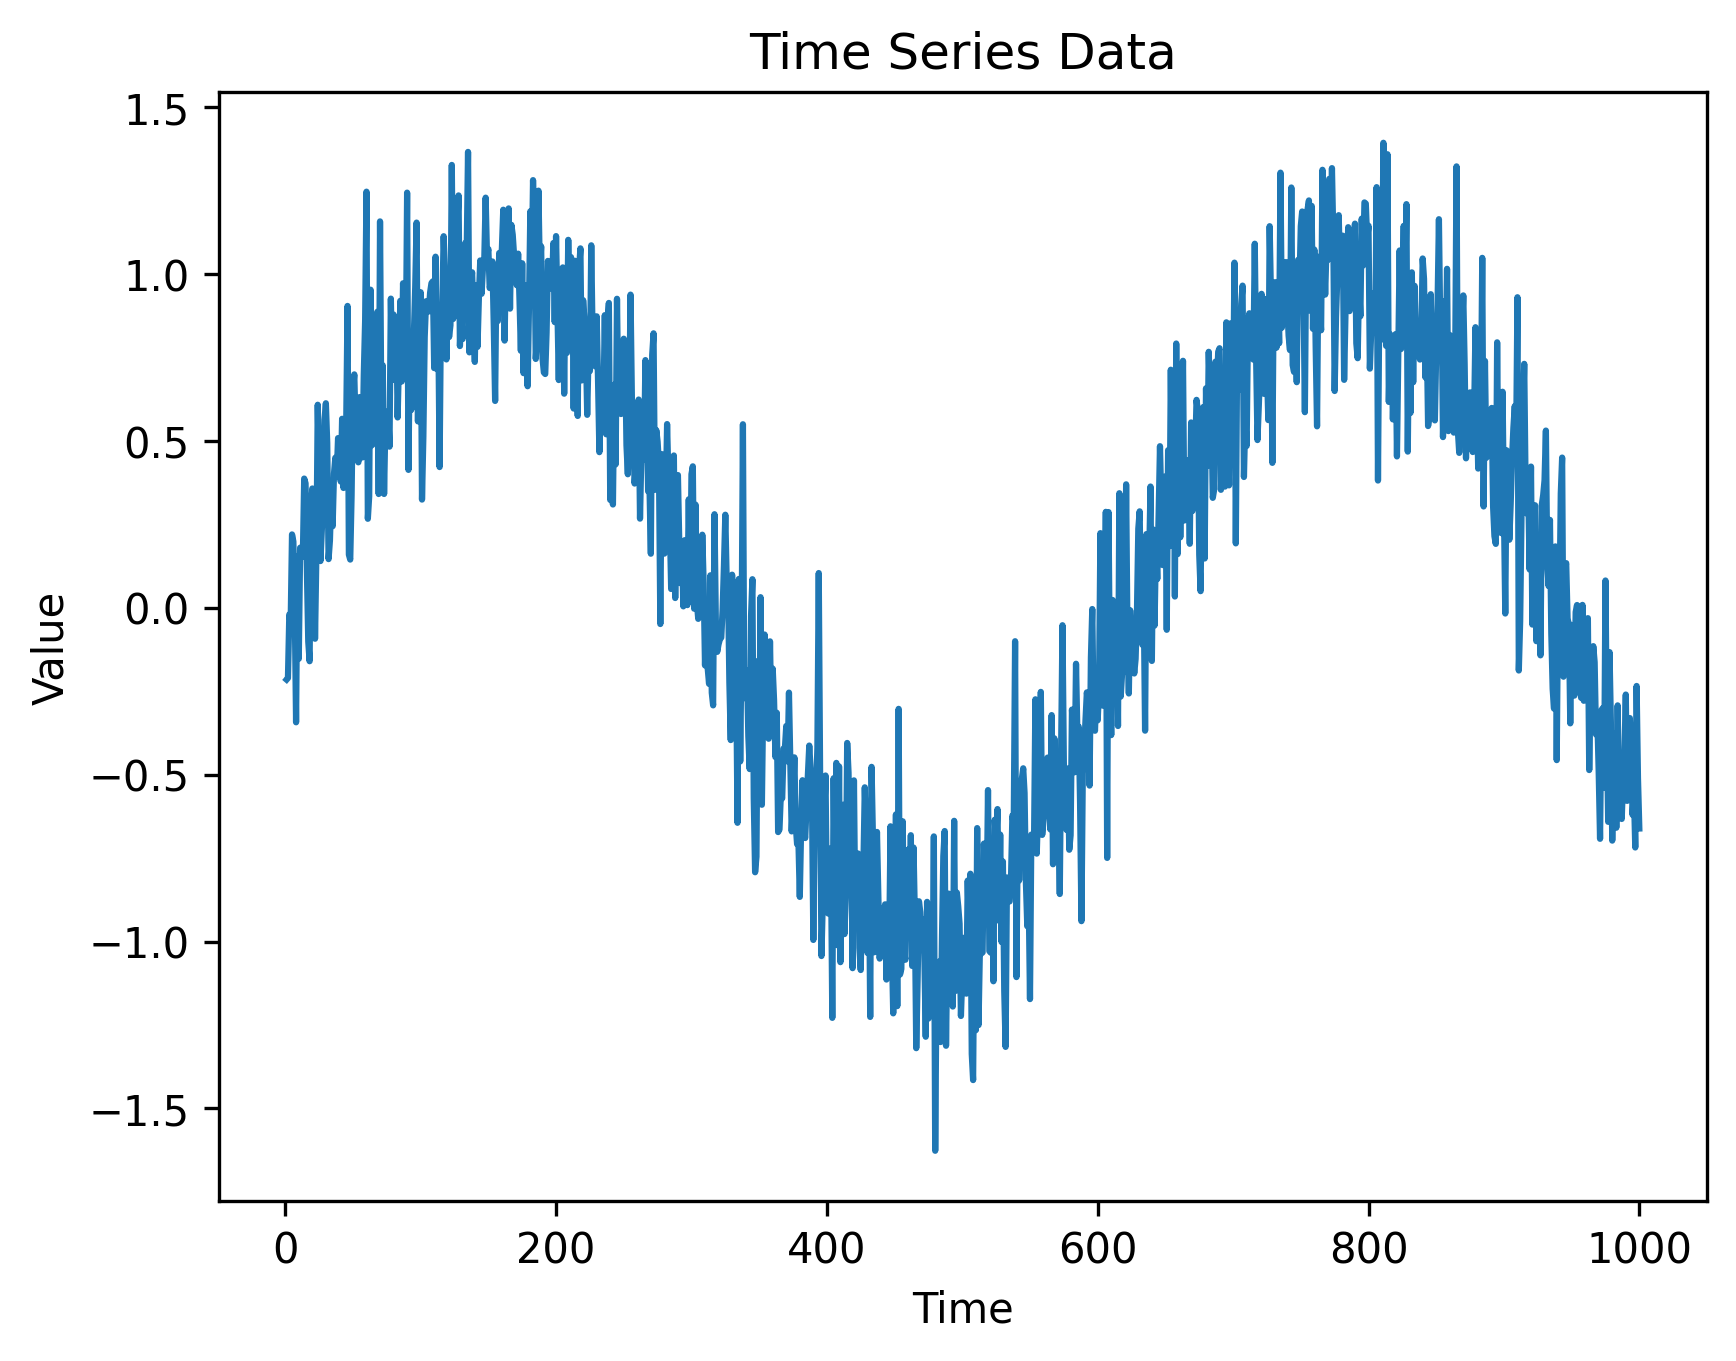

In [161]:
import torch
from torch import nn

# 设置随机种子
torch.manual_seed(0)

T = 1000  # 总共产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)  # 时间序列
x = torch.sin(time / 100) + torch.normal(0, 0.2, (T, ))

# 绘图
import matplotlib.pyplot as plt
#  设置分辨率
plt.rcParams['figure.dpi'] = 300
plt.plot(time, x)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [162]:
# 定义滞后窗口
tau = 4


# 生成特征与标签
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
# 一定要注意，labels要与features的形状匹配
# 一定要注意，labels要与features的形状匹配
# 一定要注意，labels要与features的形状匹配
labels = x[tau:].reshape(-1, 1)  # 标签需要是列向量


# 划分训练集和测试集
# 定义参数
bvatch_size = 16
train_size = 600

# 转化为TensorDataset
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(features[:train_size], labels[:train_size])
test_dataset = TensorDataset(features[train_size:], labels[train_size:])

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=bvatch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bvatch_size, shuffle=False)

In [163]:
# 定义初始化权重函数
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

# 定义模型
def get_net():
    net = nn.Sequential(
        nn.Linear(tau, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 定义损失函数
loss = nn.MSELoss(reduction="none")

In [164]:
# 准备训练
# 定义损失函数计算辅助函数
def evaluate_loss(net, data_iter, loss, device=None):
    """计算模型在数据迭代器上的损失"""
    if device is not None:
        net.to(device)
    metric = 0.0
    num_batches = 0
    for X, y in data_iter:
        if device is not None:
            X, y = X.to(device), y.to(device)
        l = loss(net(X), y).mean()
        metric += l.item()
        num_batches += 1
    return metric / num_batches

# 定义训练函数
def train(net, train_iter, test_iter, num_epochs, lr, device):
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        net.train()  # 虽然没用，但还是加一下，哈哈哈
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y).sum()
            l.backward()
            optimizer.step()
        net.eval()  # 同样，虽然没用，但还是加一下，哈哈哈
        with torch.no_grad():
            train_loss = evaluate_loss(net, train_iter, loss, device)
            test_loss = evaluate_loss(net, test_iter, loss, device)
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# 训练模型
device = torch.device("mps")
net = get_net()
num_epochs, lr = 10, 0.05
train(net, train_loader, test_loader, num_epochs, lr, device)

Epoch 1, Train Loss: 0.0724, Test Loss: 0.0683
Epoch 2, Train Loss: 0.0572, Test Loss: 0.0592
Epoch 3, Train Loss: 0.0541, Test Loss: 0.0566
Epoch 4, Train Loss: 0.0695, Test Loss: 0.0782
Epoch 5, Train Loss: 0.0584, Test Loss: 0.0561
Epoch 6, Train Loss: 0.0560, Test Loss: 0.0556
Epoch 7, Train Loss: 0.0553, Test Loss: 0.0600
Epoch 8, Train Loss: 0.0597, Test Loss: 0.0659
Epoch 9, Train Loss: 0.0690, Test Loss: 0.0614
Epoch 10, Train Loss: 0.0567, Test Loss: 0.0626


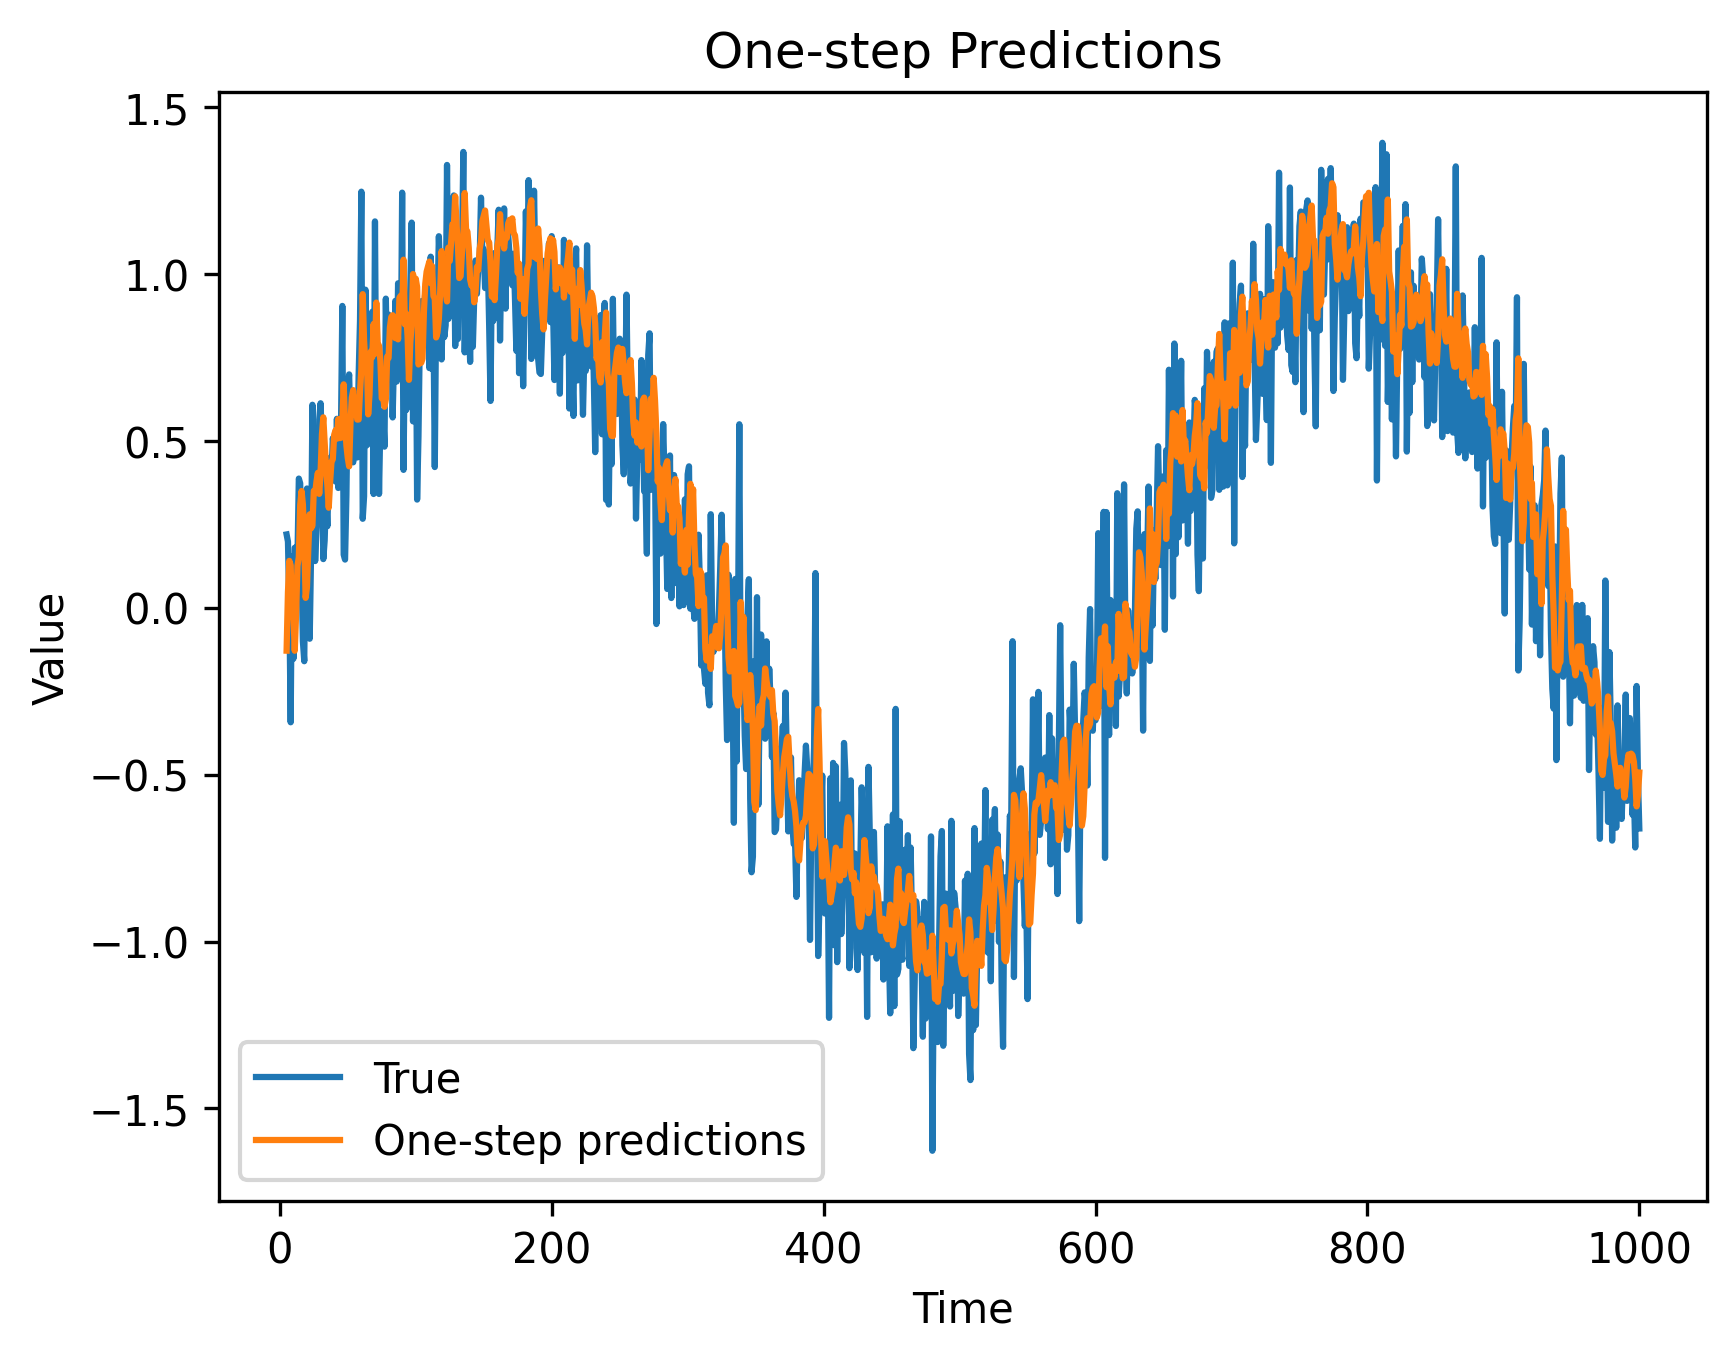

In [165]:
net.to(torch.device("cpu"))
onestep_preds = net(features)

# 绘图
plt.figure()
plt.plot(time[tau:], labels, label='True')
plt.plot(time[tau:], onestep_preds.detach(), label='One-step predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('One-step Predictions')
plt.legend()
plt.show()

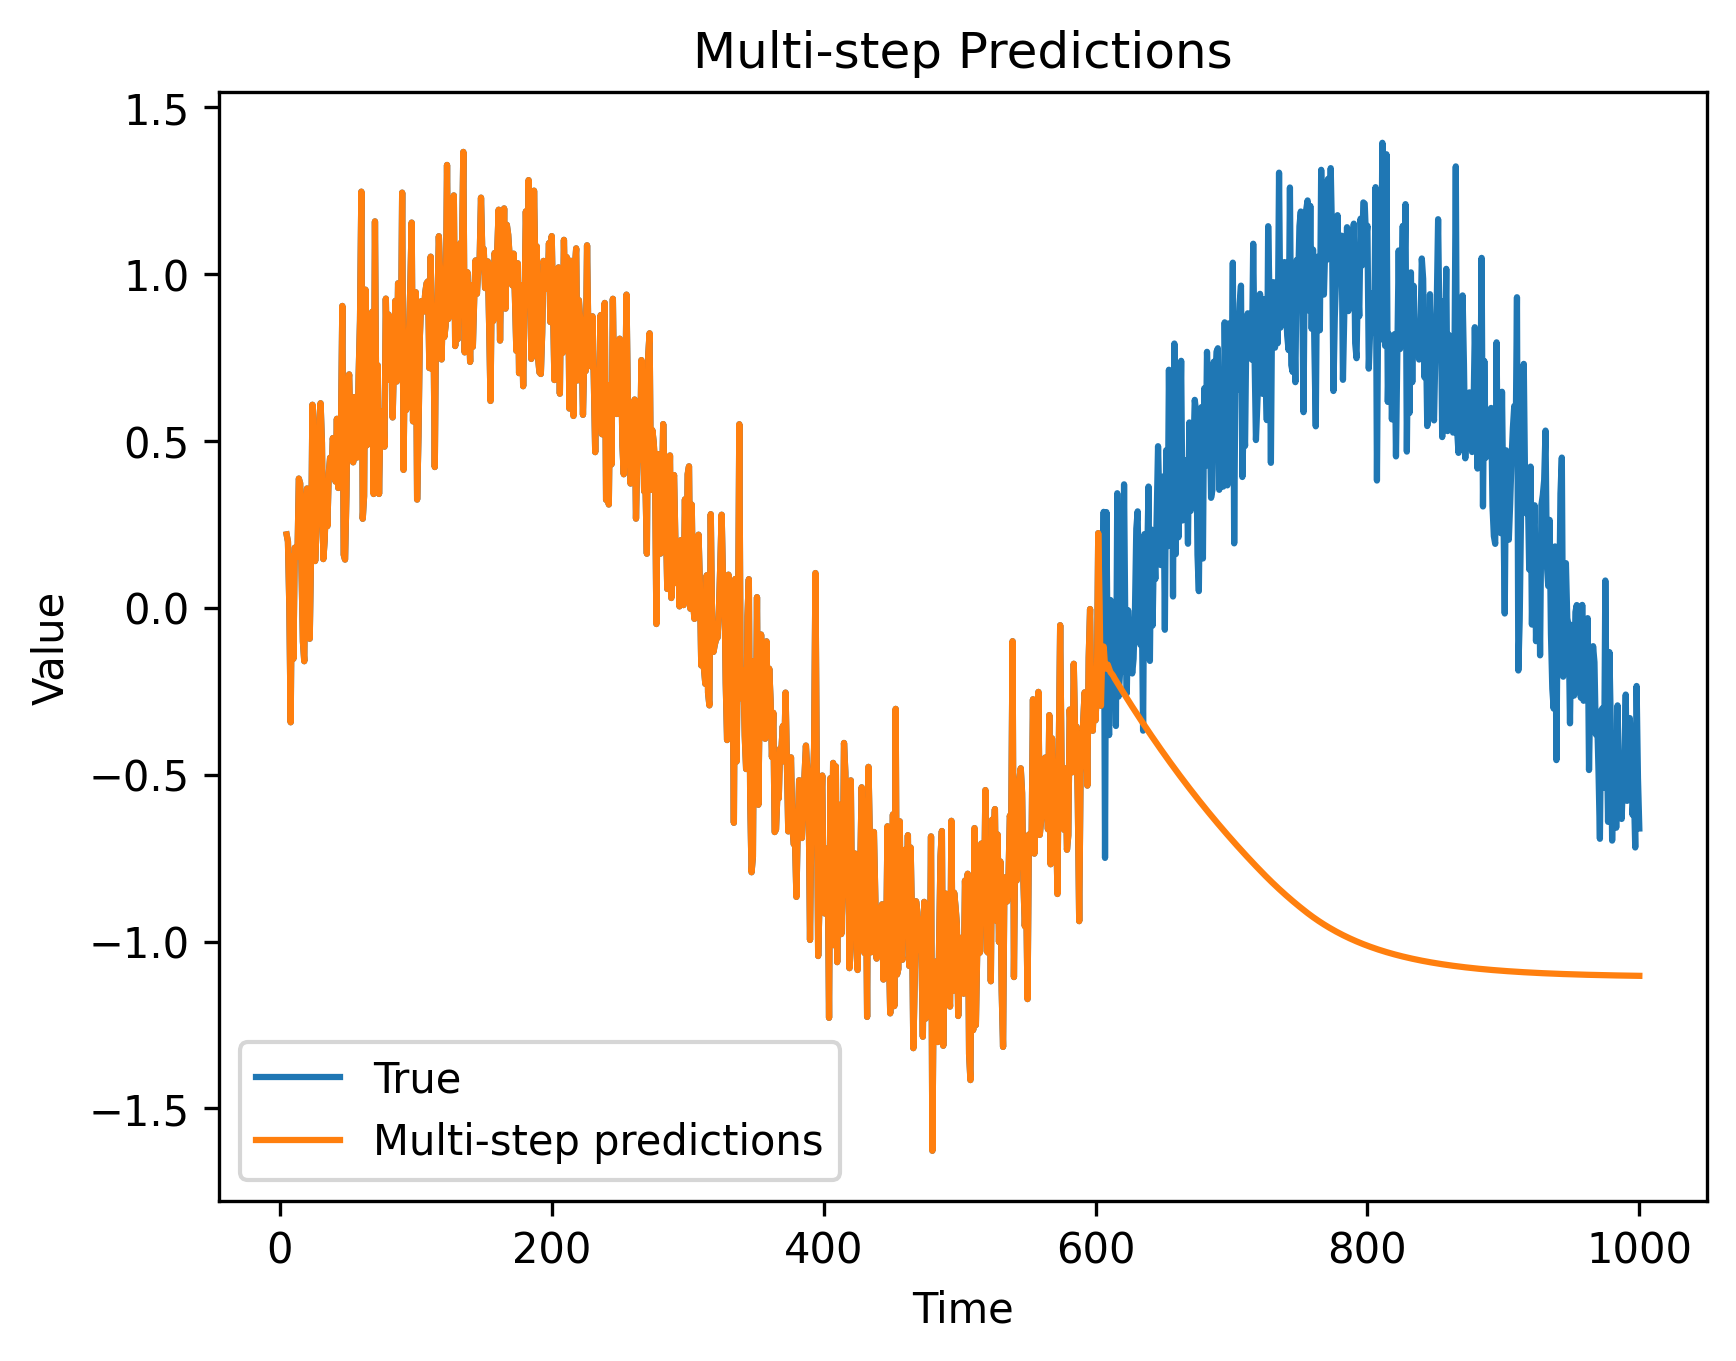

In [166]:
multistep_preds = torch.zeros(T)
multistep_preds[:train_size+tau] = x[:train_size+tau]

for i in range(train_size + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape(1, -1)).item()

# 绘图
plt.figure()
plt.plot(time[tau:], labels, label='True')
plt.plot(time[tau:], multistep_preds[tau:], label='Multi-step predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multi-step Predictions')
plt.legend()
plt.show()

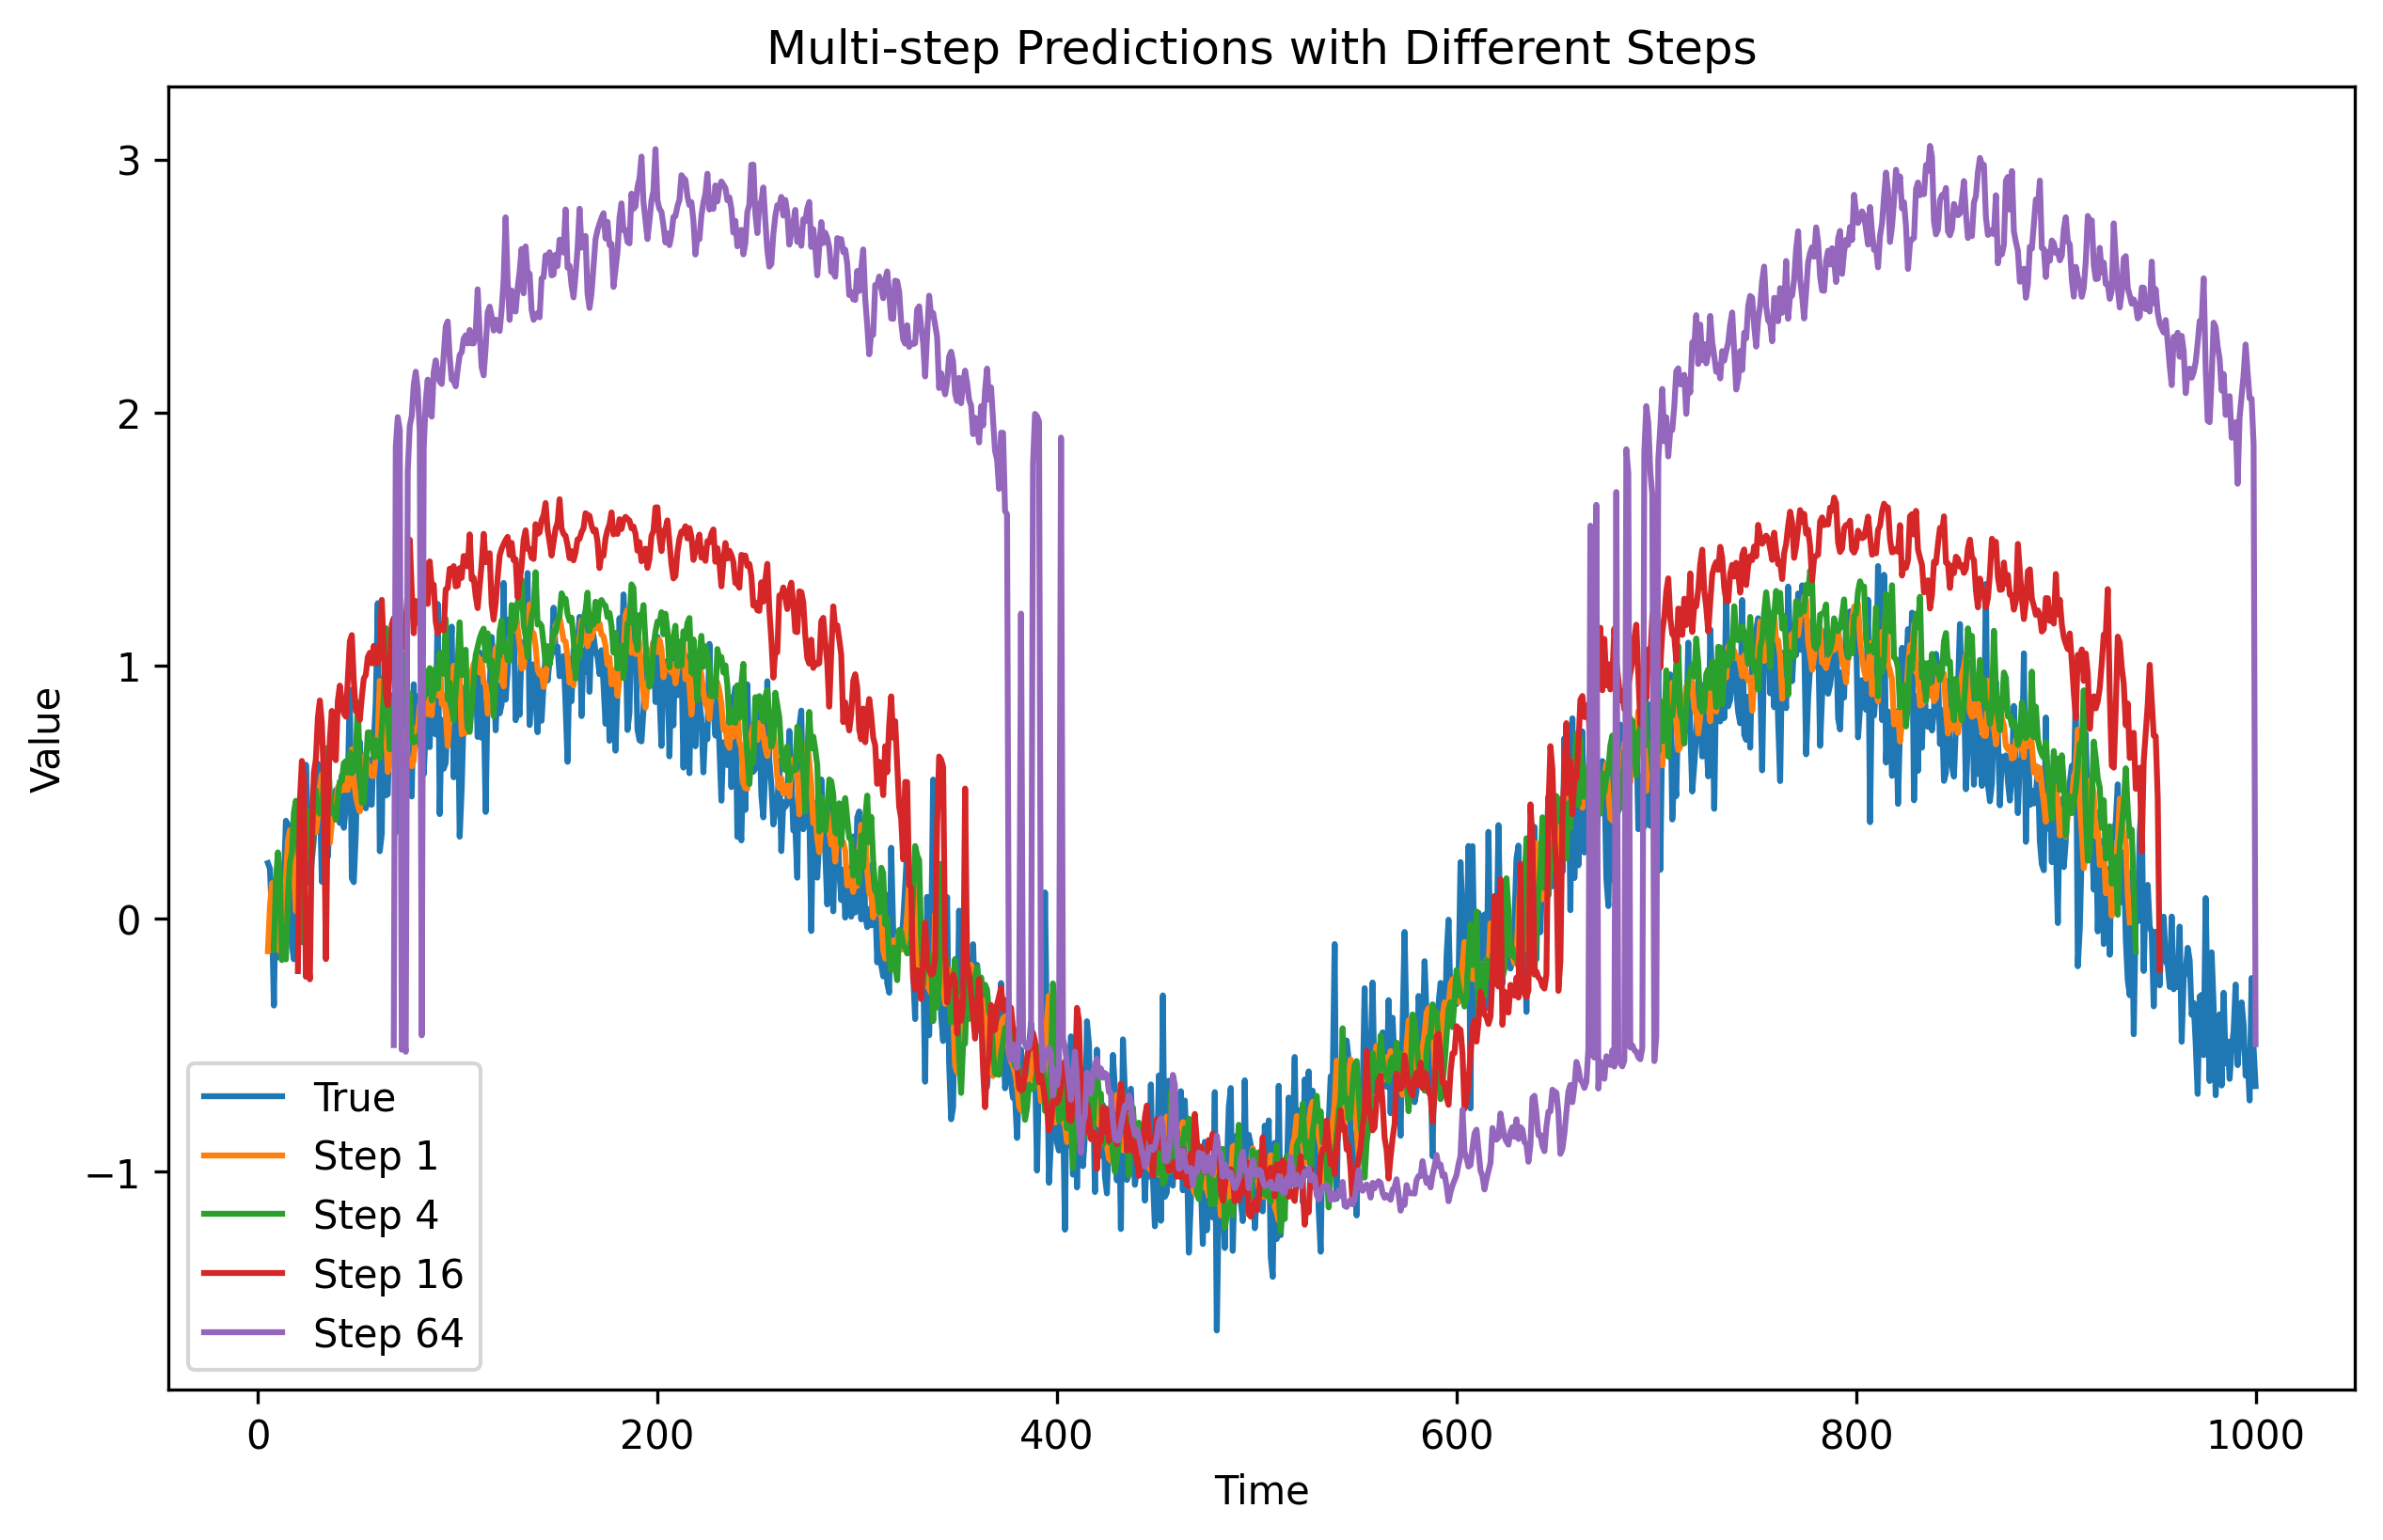

In [167]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
# 使用matplotlib绘图
plt.figure(figsize=(10, 6))
plt.plot(time[tau:], labels, label='True')
for step in steps:
    plt.plot(time[tau + step - 1:T - max_steps + step], features.detach()[:, tau + step - 1], label=f'Step {step}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multi-step Predictions with Different Steps')
plt.legend()
plt.show()

# 文本预处理

In [168]:
import os
import re
import hashlib
import urllib.request

# --- 1. 手动定义数据源信息 ---
# 之前由 d2l.DATA_HUB 和 d2l.DATA_URL 管理
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

# --- 执行并展示结果（与原代码完全相同）---
lines = read_time_machine()
if lines:
    print(f'\n# 文本总行数: {len(lines)}')
    print(lines[0])
    print(lines[10])

# 正在从 http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt 下载 timemachine.txt...
# timemachine.txt 校验成功！

# # 文本总行数: 3221
# the time machine by h g wells
# twinkled and his usually pale face was flushed and animated the

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [169]:
print(lines[0:10])

['the time machine by h g wells', '', '', '', '', 'i', '', '', 'the time traveller for so it will be convenient to speak of him', 'was expounding a recondite matter to us his grey eyes shone and']


In [170]:
def tokenize(lines, token='word'):
    """将文本行分词为单词或字符"""
    if token == 'word':
        # 使用空格分词
        return [line.split() for line in lines]
    elif token == 'char':
        # 将每行转换为字符列表
        return [list(line) for line in lines]
    else:
        raise ValueError("token must be either 'word' or 'char'")

tokens = tokenize(lines, 'word')
print(tokens[0:10])  # 打印前10行的分词结果

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells'], [], [], [], [], ['i'], [], [], ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him'], ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']]


In [171]:
# 定义辅助函数统计词频
def count_corpus(tokens):
    """统计词频"""
    from collections import Counter
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]  # 扁平化列表
    return Counter(tokens)

# 定义词表类
class Vocab:
    """词表类"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # 空词表初始化
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        # 统计词频
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 设置idx与token的映射
        self.idx_to_token = ["<unk>"] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        # 添加频率大于等于min_freq的词
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    
    # 获取词表大小
    def __len__(self):
        return len(self.idx_to_token)
    
    # 获取token对应的idx
    def __getitem__(self, tokens):
        # 这是一个递归
        # 如果tokens不是列表或元组，则返回对应的idx
        # 如果是列表或元组，则对元素再次调用__getitem__
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]
    
    # 获取idx对应的token
    def idx_to_tokens(self, indices):
        # 同样也是递归
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[idx] for idx in indices]
    
    # 获取unk的idx
    @property
    def unk(self):
        return 0
    
    # 获取词频
    @property
    def token_freqs(self):
        return self._token_freqs

vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [172]:
tokens[0]

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']

In [173]:
vocab[tokens[0]]

[1, 19, 50, 40, 2183, 2184, 400]

In [174]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

# (170580, 28)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


(170580, 28)

# 学习语言模型

In [175]:
def seq_data_iter_random(corpus, batch_size, num_steps): 
    import random

    # 讲一下实现思路
    # 随机选择起始位置，在0到num_steps-1之间
    # 从起始位置每隔num_steps个位置取每个序列开始位置
    # shuffle打乱顺序，即为随机
    # 从序列开始位置列表中按batch_size个取出batch

    # 随机选择起始位置
    corpus = corpus[random.randint(0, num_steps - 1):]

    # 计算序列数量
    num_subseqs = (len(corpus) - 1) // num_steps

    # 生成序列开始位置
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))

    # 打乱序列开始位置
    random.shuffle(initial_indices)

    # 计算batch数量
    num_batches = len(initial_indices) // batch_size

    # 生成batch
    for i in range(num_batches):
        batch_indices = initial_indices[i * batch_size: (i + 1) * batch_size]
        X = [corpus[idx: idx + num_steps] for idx in batch_indices]
        Y = [corpus[idx + 1: idx + num_steps + 1] for idx in batch_indices]
        yield torch.tensor(X), torch.tensor(Y)

In [176]:
import torch
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[11, 12, 13, 14, 15],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [27, 28, 29, 30, 31]])
X:  tensor([[16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [22, 23, 24, 25, 26]])
X:  tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [ 7,  8,  9, 10, 11]])


In [177]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [178]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [179]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 循环神经网络的简洁实现

In [180]:
import os
import re
import hashlib
import urllib.request
import collections


DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    import random

    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [181]:
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [182]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [183]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

开始在 mps 上训练...


Epoch 10, Perplexity 11.2, Speed 79108.5 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 20, Perplexity 9.1, Speed 44191.0 tokens/sec
  预测 'time traveller': time travellere the and the the the the the the the the the the 
Epoch 30, Perplexity 8.7, Speed 70153.5 tokens/sec
  预测 'time traveller': time traveller the this this thing the thimenston thingthing the
Epoch 40, Perplexity 7.8, Speed 52678.3 tokens/sec
  预测 'time traveller': time traveller and and and and and and and and and and and and a
Epoch 50, Perplexity 7.2, Speed 67379.1 tokens/sec
  预测 'time traveller': time traveller the this the this the the the the the the the the
Epoch 60, Perplexity 6.6, Speed 74457.7 tokens/sec
  预测 'time traveller': time traveller and and the cadien sions of chathe thane the this
Epoch 70, Perplexity 6.2, Speed 76116.1 tokens/sec
  预测 'time traveller': time traveller all tha the mane the and the tire treertimensions
Epoch 80, Perplexity 5.4, 

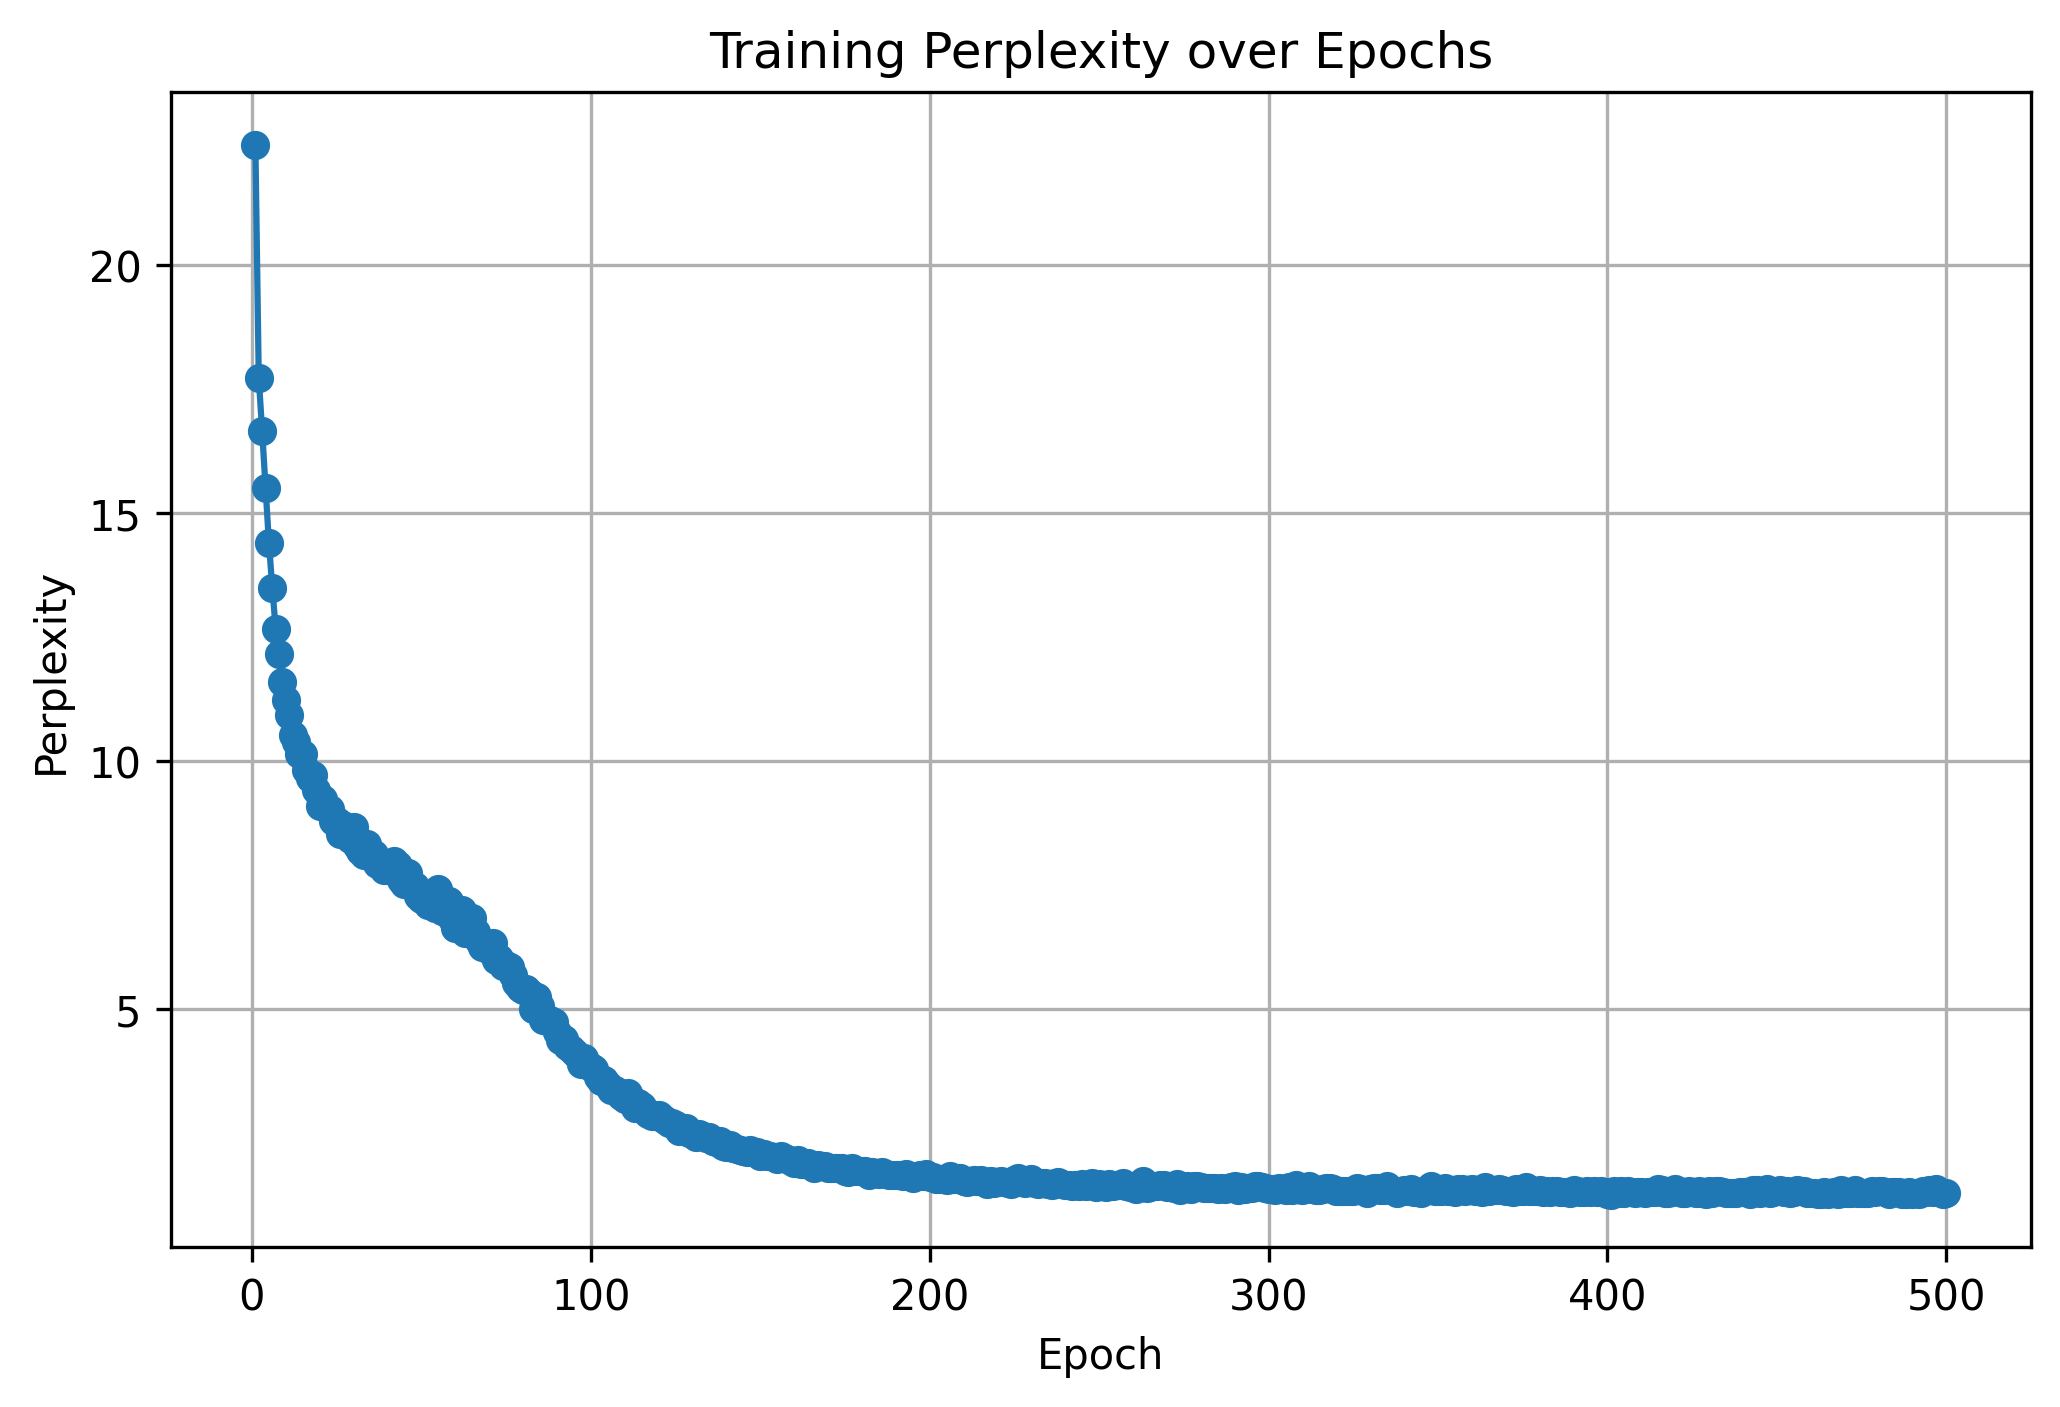

In [184]:
import torch
import torch.nn as nn
import math
import time
import matplotlib.pyplot as plt

# ==================================================================
# 1. 必需的辅助函数 (替代 d2l 的功能)
# ==================================================================

def grad_clipping(net, theta):
    """裁剪梯度 (使用PyTorch内置函数实现)"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
        torch.nn.utils.clip_grad_norm_(params, theta)

def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    # 将网络设置为评估模式
    net.eval()
    # 初始化隐藏状态
    state = net.begin_state(batch_size=1, device=device)
    # 将前缀文本转换为数字索引
    outputs = [vocab[prefix[0]]]
    # 预热阶段：用前缀来更新隐藏状态
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    # 预测阶段：生成 num_preds 个新字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        
    # 将生成的数字索引转换回文本
    return ''.join([vocab.to_tokens(i) for i in outputs])

# ==================================================================
# 2. 合并后的主训练函数
# ==================================================================

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
                         use_random_iter=False):
    """
    训练语言模型 (不依赖d2l库的整合版本)

    :param net: 神经网络模型 (nn.Module)
    :param train_iter: 训练数据迭代器
    :param vocab: 词汇表对象
    :param lr: 学习率
    :param num_epochs: 训练周期数
    :param device: 训练设备 (cpu, cuda, mps)
    :param use_random_iter: 是否使用随机采样迭代器
    """
    # --- 初始化 ---
    print(f"开始在 {device} 上训练...")
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr)
    
    # 用于存储每个epoch的困惑度，以供最后绘图
    history = []

    # --- 训练循环 ---
    for epoch in range(num_epochs):
        # --- 单个迭代周期的逻辑 (原 train_epoch_ch8) ---
        state, timer_start = None, time.time()
        
        # 替代 d2l.Accumulator
        total_loss = 0.0
        total_tokens = 0
        
        # 将网络设置为训练模式
        net.train()

        for X, Y in train_iter:
            # 初始化或分离隐藏状态
            if state is None or use_random_iter:
                state = net.begin_state(batch_size=X.shape[0], device=device)
            else:
                if isinstance(state, tuple): # for LSTM
                    for s in state:
                        s.detach_()
                else: # for GRU
                    state.detach_()

            # 准备数据和标签
            y = Y.T.reshape(-1)
            X, y = X.to(device), y.to(device)
            
            # 前向传播和计算损失
            y_hat, state = net(X, state)
            l = loss(y_hat, y.long()).mean()
            
            # 反向传播和更新参数
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) # 梯度裁剪
            updater.step()
            
            # 累加损失和词元数量
            total_loss += l.item() * y.numel()
            total_tokens += y.numel()

        # --- epoch结束后的计算和打印 ---
        elapsed_time = time.time() - timer_start
        # 计算困惑度 (Perplexity)
        ppl = math.exp(total_loss / total_tokens)
        speed = total_tokens / elapsed_time
        
        # 将结果存入列表
        history.append((epoch + 1, ppl))
        
        # 每10个epoch打印一次预测结果
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Perplexity {ppl:.1f}, "
                  f"Speed {speed:.1f} tokens/sec")
            # 调用我们自己实现的预测函数
            print("  预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))

    # --- 训练结束后的总结和绘图 ---
    final_ppl = history[-1][1]
    print(f'\n训练完成。最终困惑度 {final_ppl:.1f}, {speed:.1f} 词元/秒 on {str(device)}')
    print("最终预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))
    print("最终预测 'traveller':", predict_ch8('traveller', 50, net, vocab, device))
    
    # --- 使用 Matplotlib 绘图 ---
    print("\n正在生成困惑度曲线图...")
    epochs, perplexities = zip(*history) # 解包历史记录
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, perplexities, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training Perplexity over Epochs')
    plt.grid(True)
    plt.show()

num_epochs, lr = 500, 1
net = RNNModel(rnn_layer, vocab_size=len(vocab))
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
net = net.to(device)
train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False)

# GRU

In [185]:
vocab_size, num_hiddens, device = len(vocab), 256, "mps"
num_epochs, lr = 500, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

开始在 mps 上训练...
Epoch 10, Perplexity 15.6, Speed 30780.3 tokens/sec
  预测 'time traveller': time travellere tate tate tate tate tate tate tate tate tate tat
Epoch 20, Perplexity 12.2, Speed 31891.7 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 30, Perplexity 10.7, Speed 31977.4 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 40, Perplexity 10.3, Speed 32046.3 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 50, Perplexity 9.6, Speed 30078.9 tokens/sec
  预测 'time traveller': time traveller and the the the the the the the the the the the t
Epoch 60, Perplexity 9.1, Speed 29269.5 tokens/sec
  预测 'time traveller': time travellerere the the the the the the the the the the the th
Epoch 70, Perplexity 8.7, Speed 31970.7 tokens/sec
  预测 'time traveller': time travellerere the there the there the there the there the th
Epoch 80

KeyboardInterrupt: 

开始在 mps 上训练...
Epoch 10, Perplexity 15.8, Speed 30957.5 tokens/sec
  预测 'time traveller': time traveller t a t a t a t a t a t a t a t a t a t a t a t a t
Epoch 20, Perplexity 12.4, Speed 30051.1 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 30, Perplexity 10.8, Speed 30385.7 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 40, Perplexity 10.2, Speed 31000.4 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 50, Perplexity 9.9, Speed 31227.1 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 60, Perplexity 9.4, Speed 31446.8 tokens/sec
  预测 'time traveller': time travellererere the the the the the the the the the the the 
Epoch 70, Perplexity 9.1, Speed 30144.7 tokens/sec
  预测 'time traveller': time travellerererentins and and the there there there there the
Epoch 80

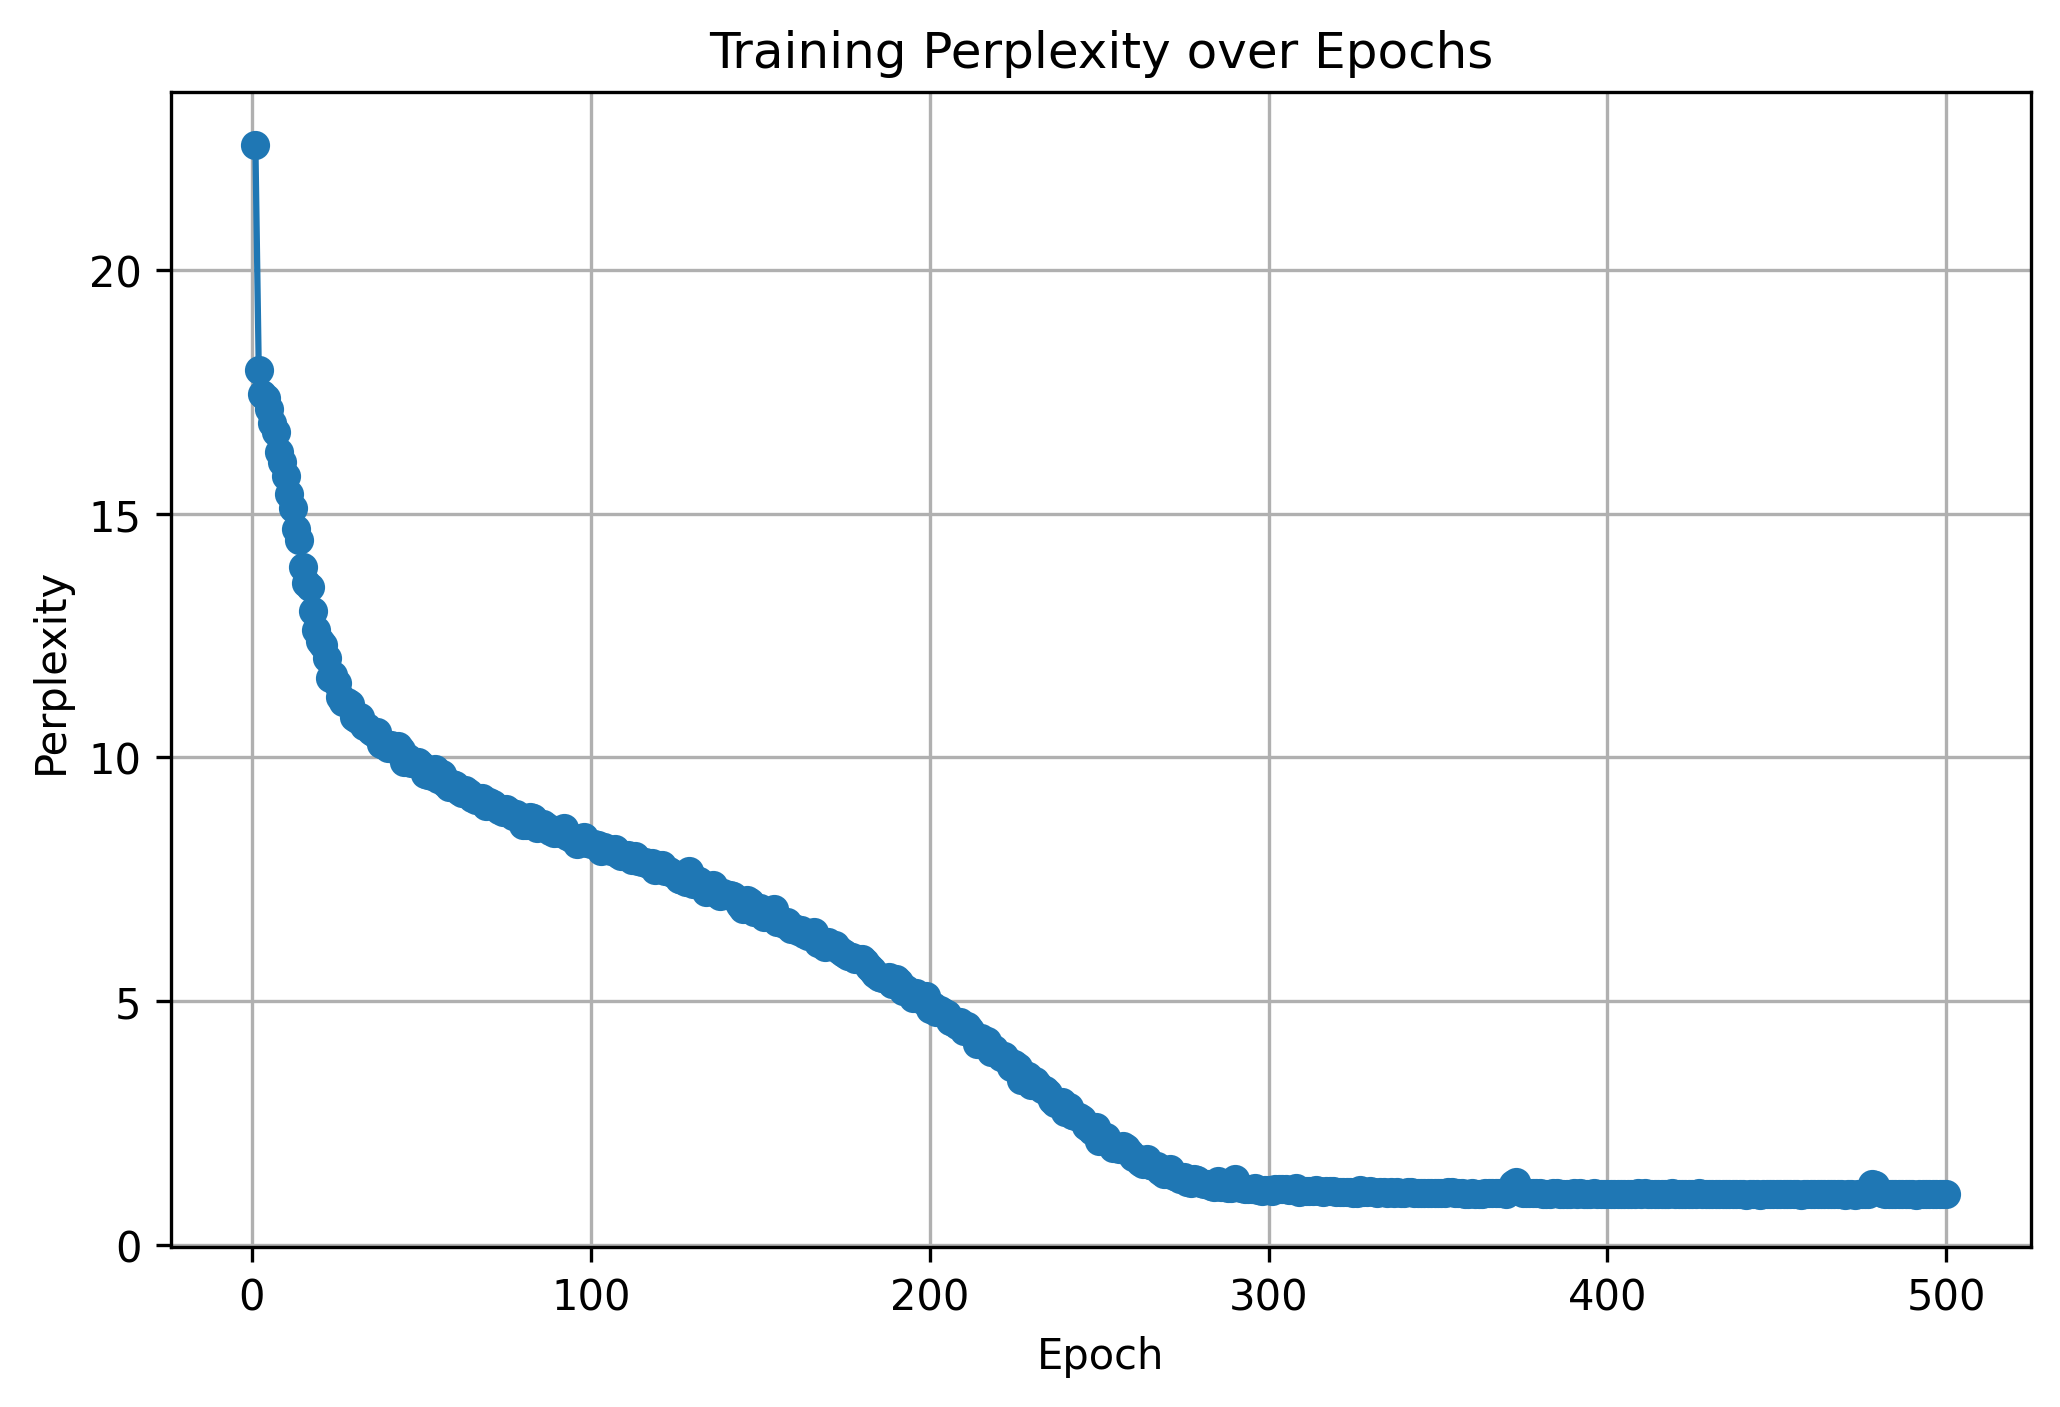

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 512, "mps"
num_epochs, lr = 500, 1
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# LSTM

开始在 mps 上训练...
Epoch 10, Perplexity 17.2, Speed 171849.0 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 20, Perplexity 16.2, Speed 164205.1 tokens/sec
  预测 'time traveller': time traveller t at t at t at a t at t at a t at t at a t at t a
Epoch 30, Perplexity 14.2, Speed 153877.8 tokens/sec
  预测 'time traveller': time traveller te te the te the te the te the te the te the te t
Epoch 40, Perplexity 12.3, Speed 132997.0 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 50, Perplexity 11.4, Speed 171562.6 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 60, Perplexity 10.5, Speed 168216.0 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 70, Perplexity 10.0, Speed 156332.0 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the

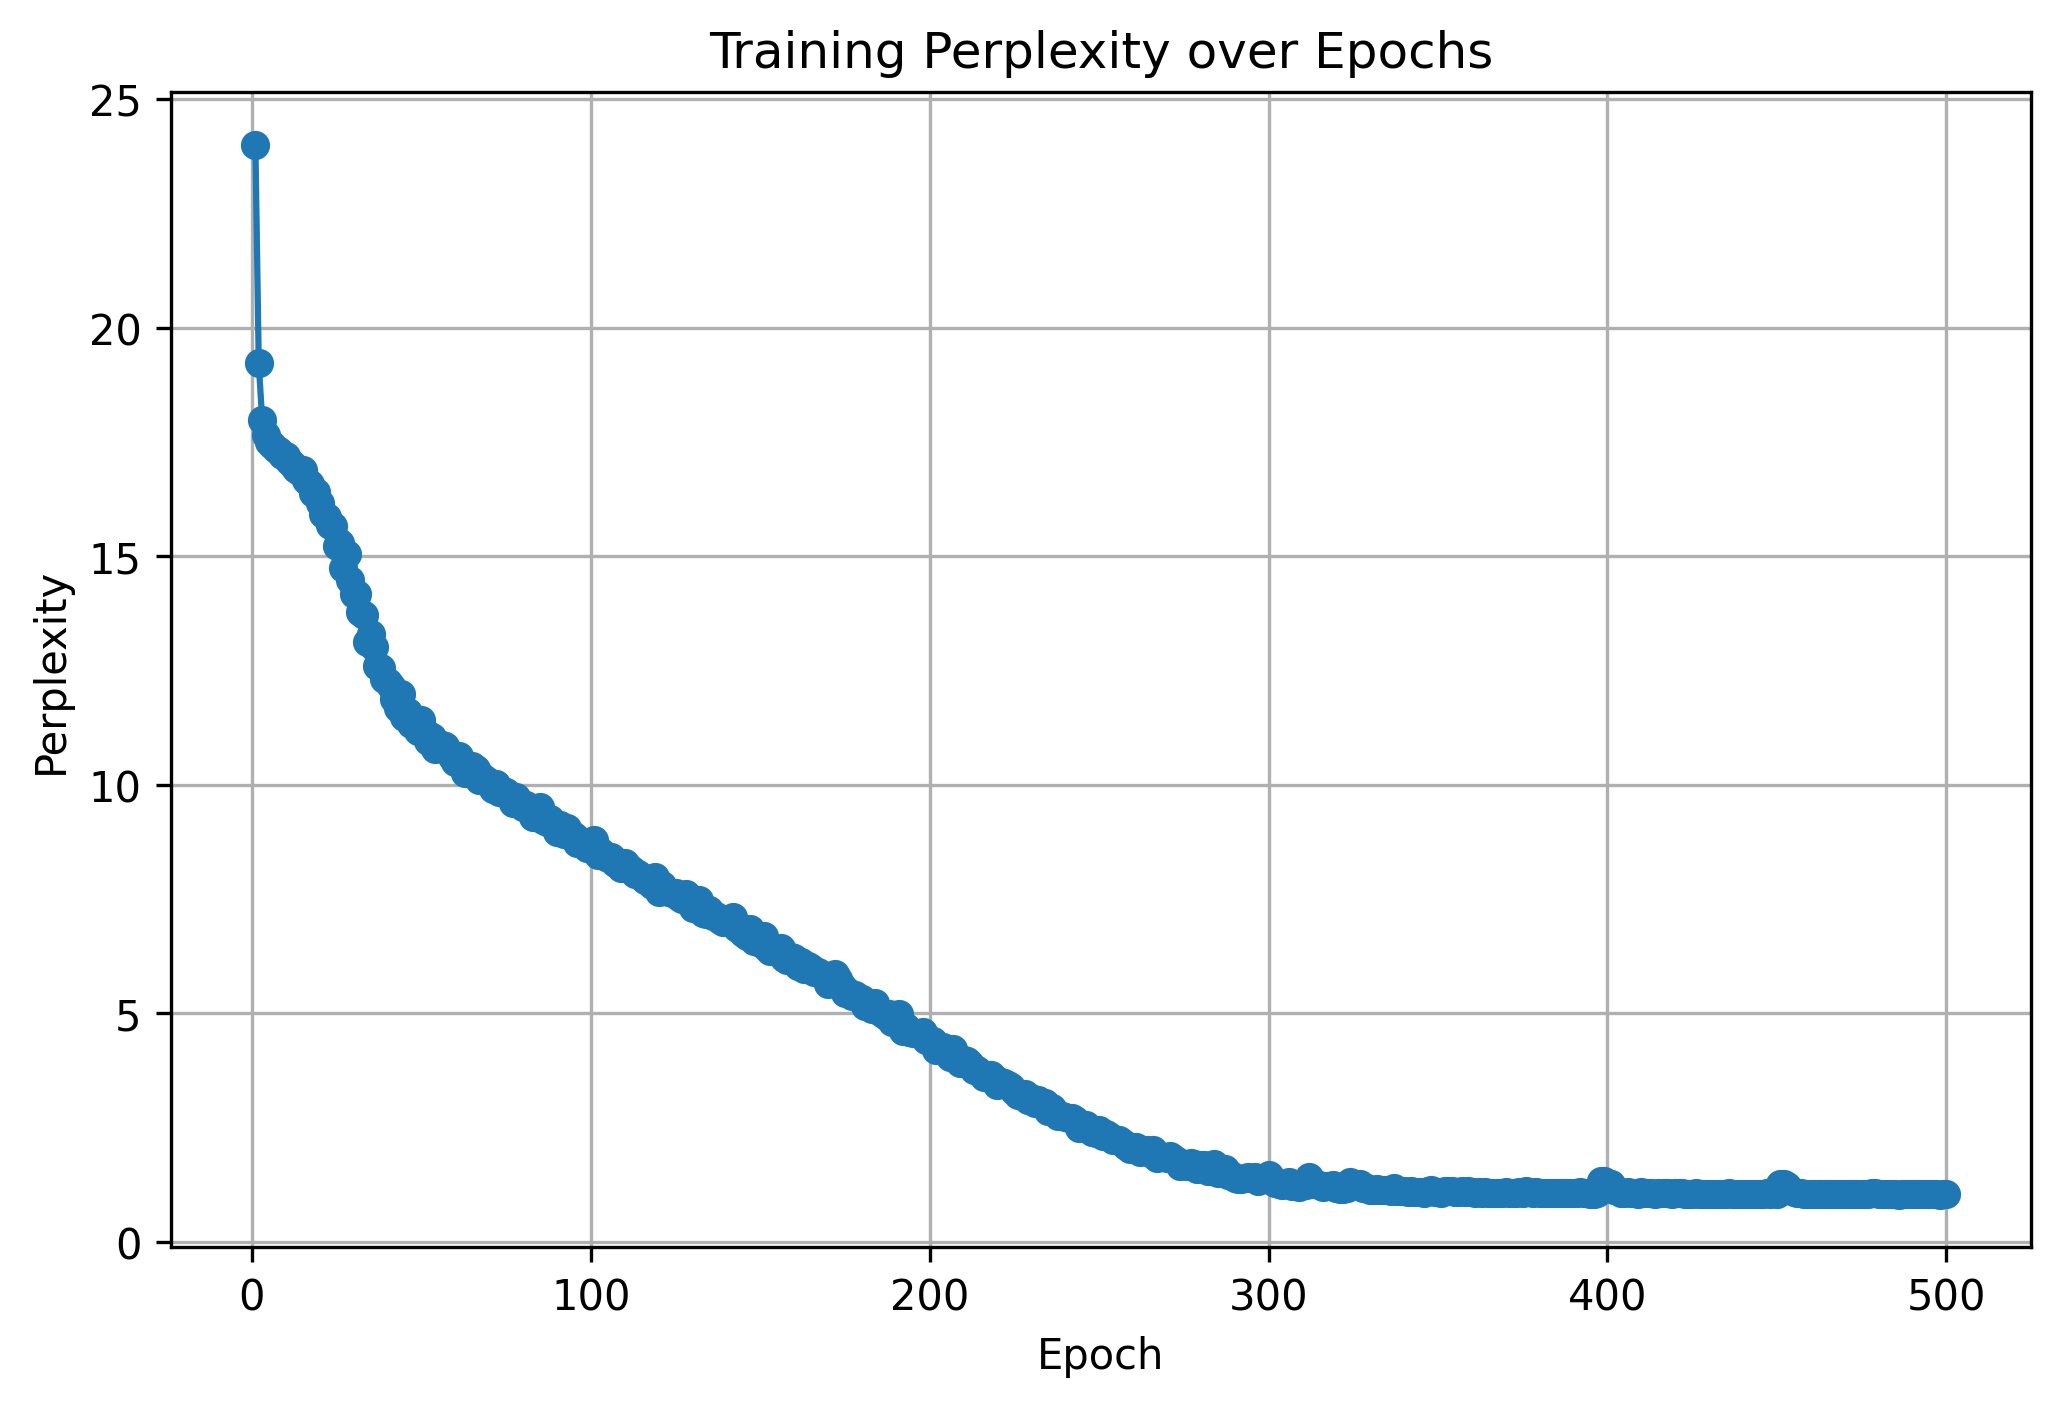

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, "mps"
num_epochs, lr = 500, 1
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

开始在 mps 上训练...
Epoch 10, Perplexity 17.5, Speed 123400.8 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 20, Perplexity 17.4, Speed 97021.2 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 30, Perplexity 17.4, Speed 110058.7 tokens/sec
  预测 'time traveller': time travellereee eeeee eeeee eeeee eeeee eeeee eeeee eeeee eeee
Epoch 40, Perplexity 15.9, Speed 118824.8 tokens/sec
  预测 'time traveller': time traveller ta a ae a ae a ae a ae a ae a ae a ae a ae a ae a
Epoch 50, Perplexity 14.8, Speed 115559.1 tokens/sec
  预测 'time traveller': time traveller aa ae tae tae tae tae tae tae tae tae tae tae tae
Epoch 60, Perplexity 12.8, Speed 120372.3 tokens/sec
  预测 'time traveller': time traveller the the the the the the the the the the the the t
Epoch 70, Perplexity 11.3, Speed 136450.6 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 

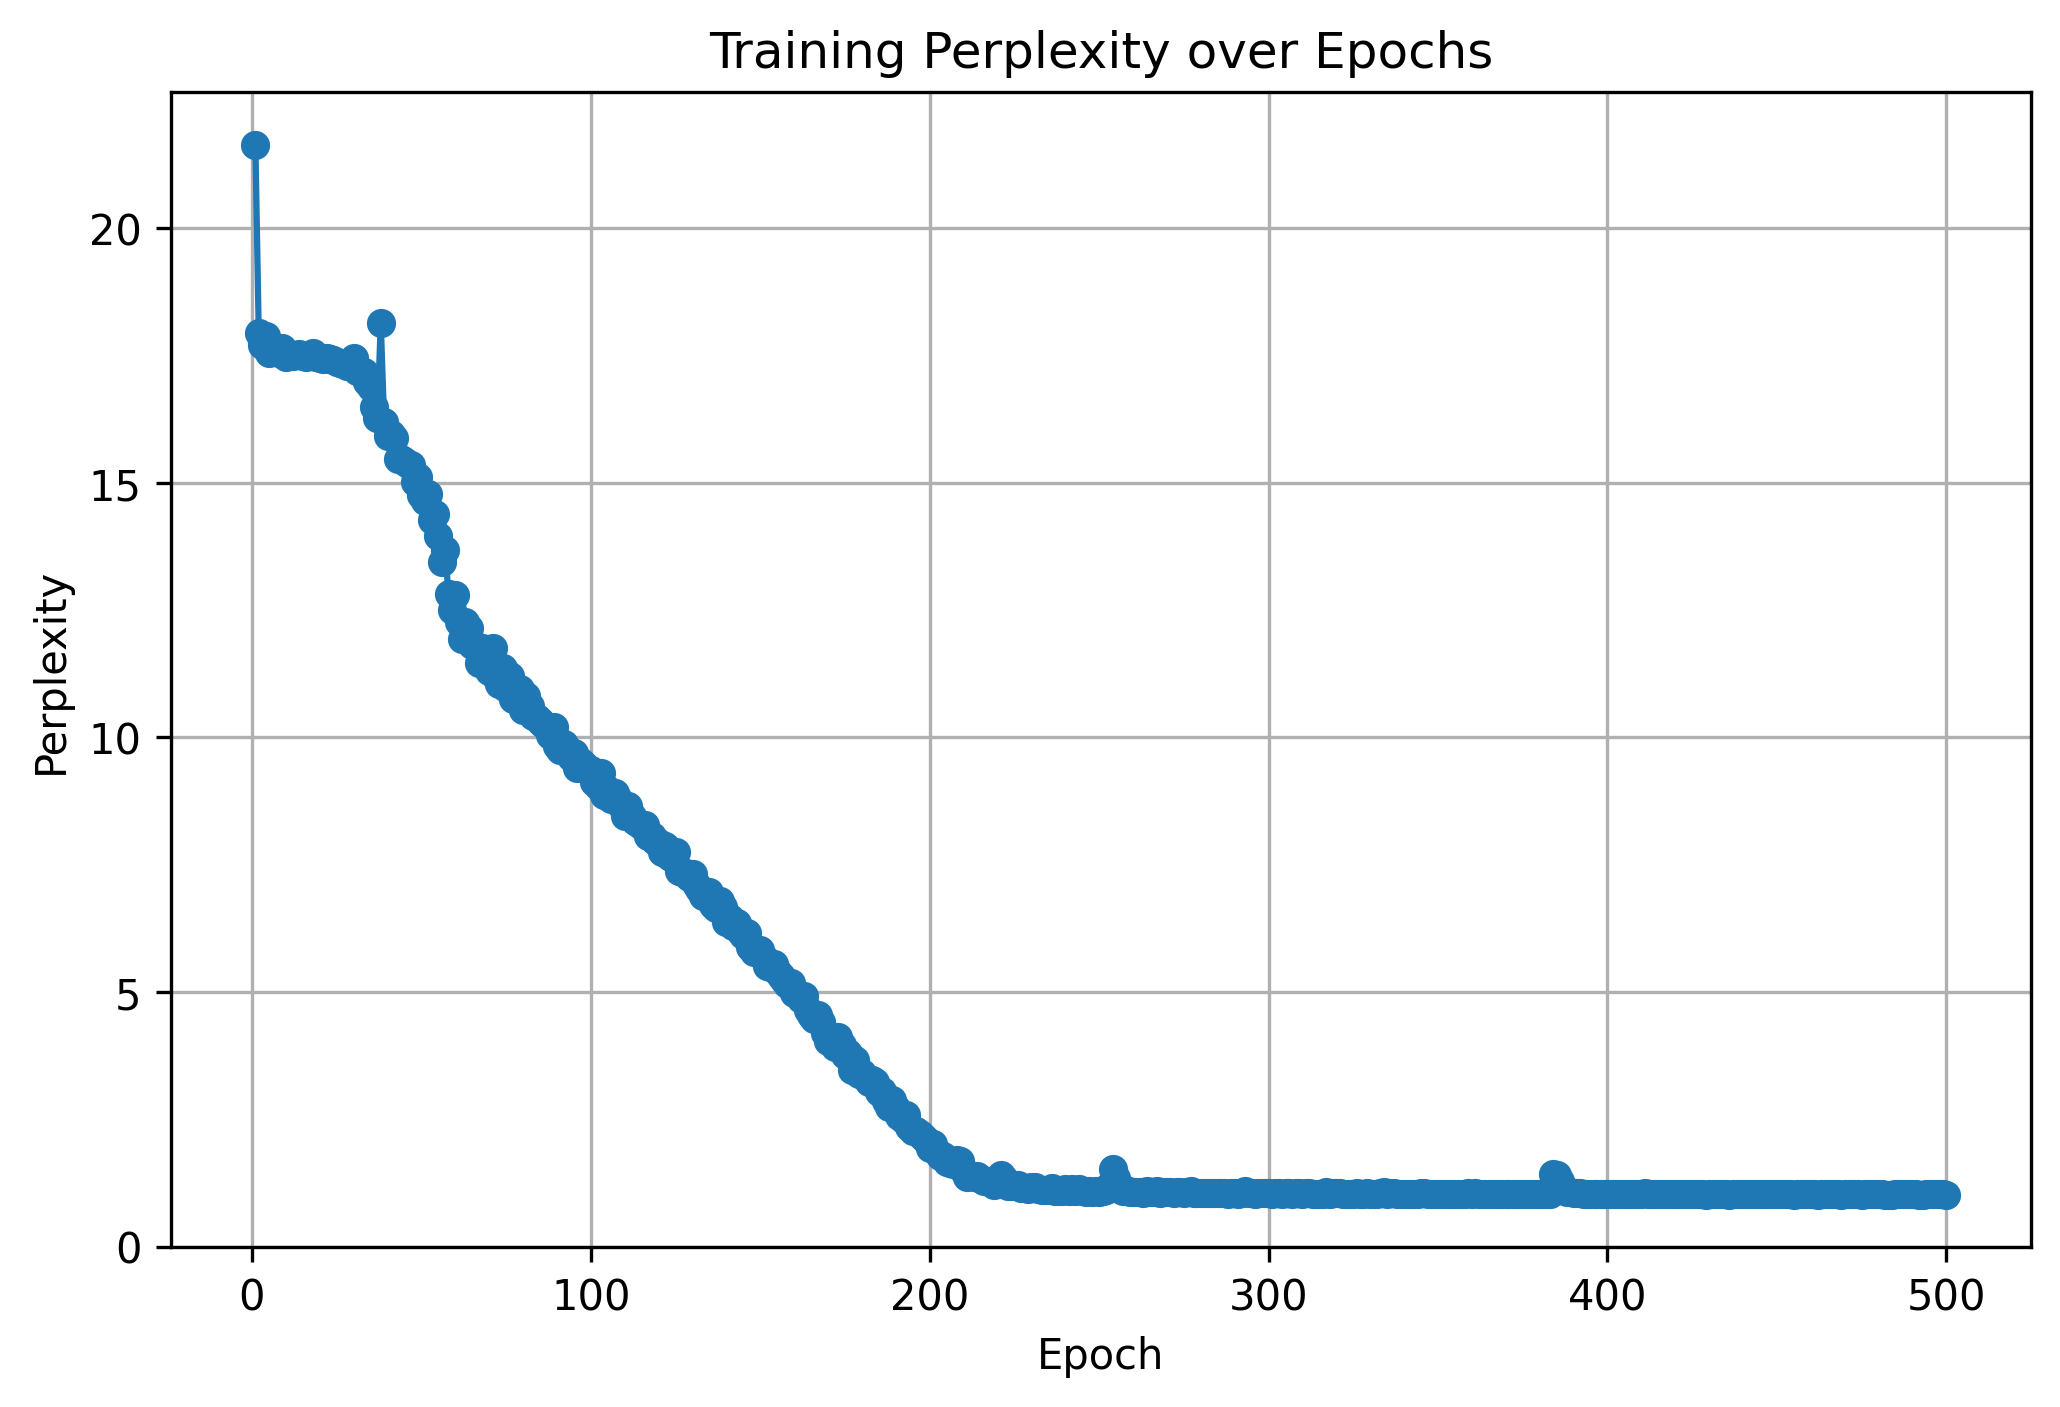

In [ ]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = "mps"
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

# 双向循环网络

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！
开始在 mps 上训练...
Epoch 10, Perplexity 17.4, Speed 62993.5 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 20, Perplexity 17.1, Speed 62616.6 tokens/sec
  预测 'time traveller': time traveller                                                  
Epoch 30, Perplexity 15.9, Speed 62553.3 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 40, Perplexity 9.2, Speed 62835.4 tokens/sec
  预测 'time traveller': time travellereeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee
Epoch 50, Perplexity 4.0, Speed 62313.1 tokens/sec
  预测 'time traveller': time travellerererererererererererererererererererererererererer
Epoch 60, Perplexity 2.0, Speed 63005.4 tokens/sec
  预测 'time traveller': time travellerererererererererererererererererererererererererer
Epoch 70, Perplexity 1.6, Speed 55703.1 tokens/sec
  预测 'time traveller': time travellererererererer

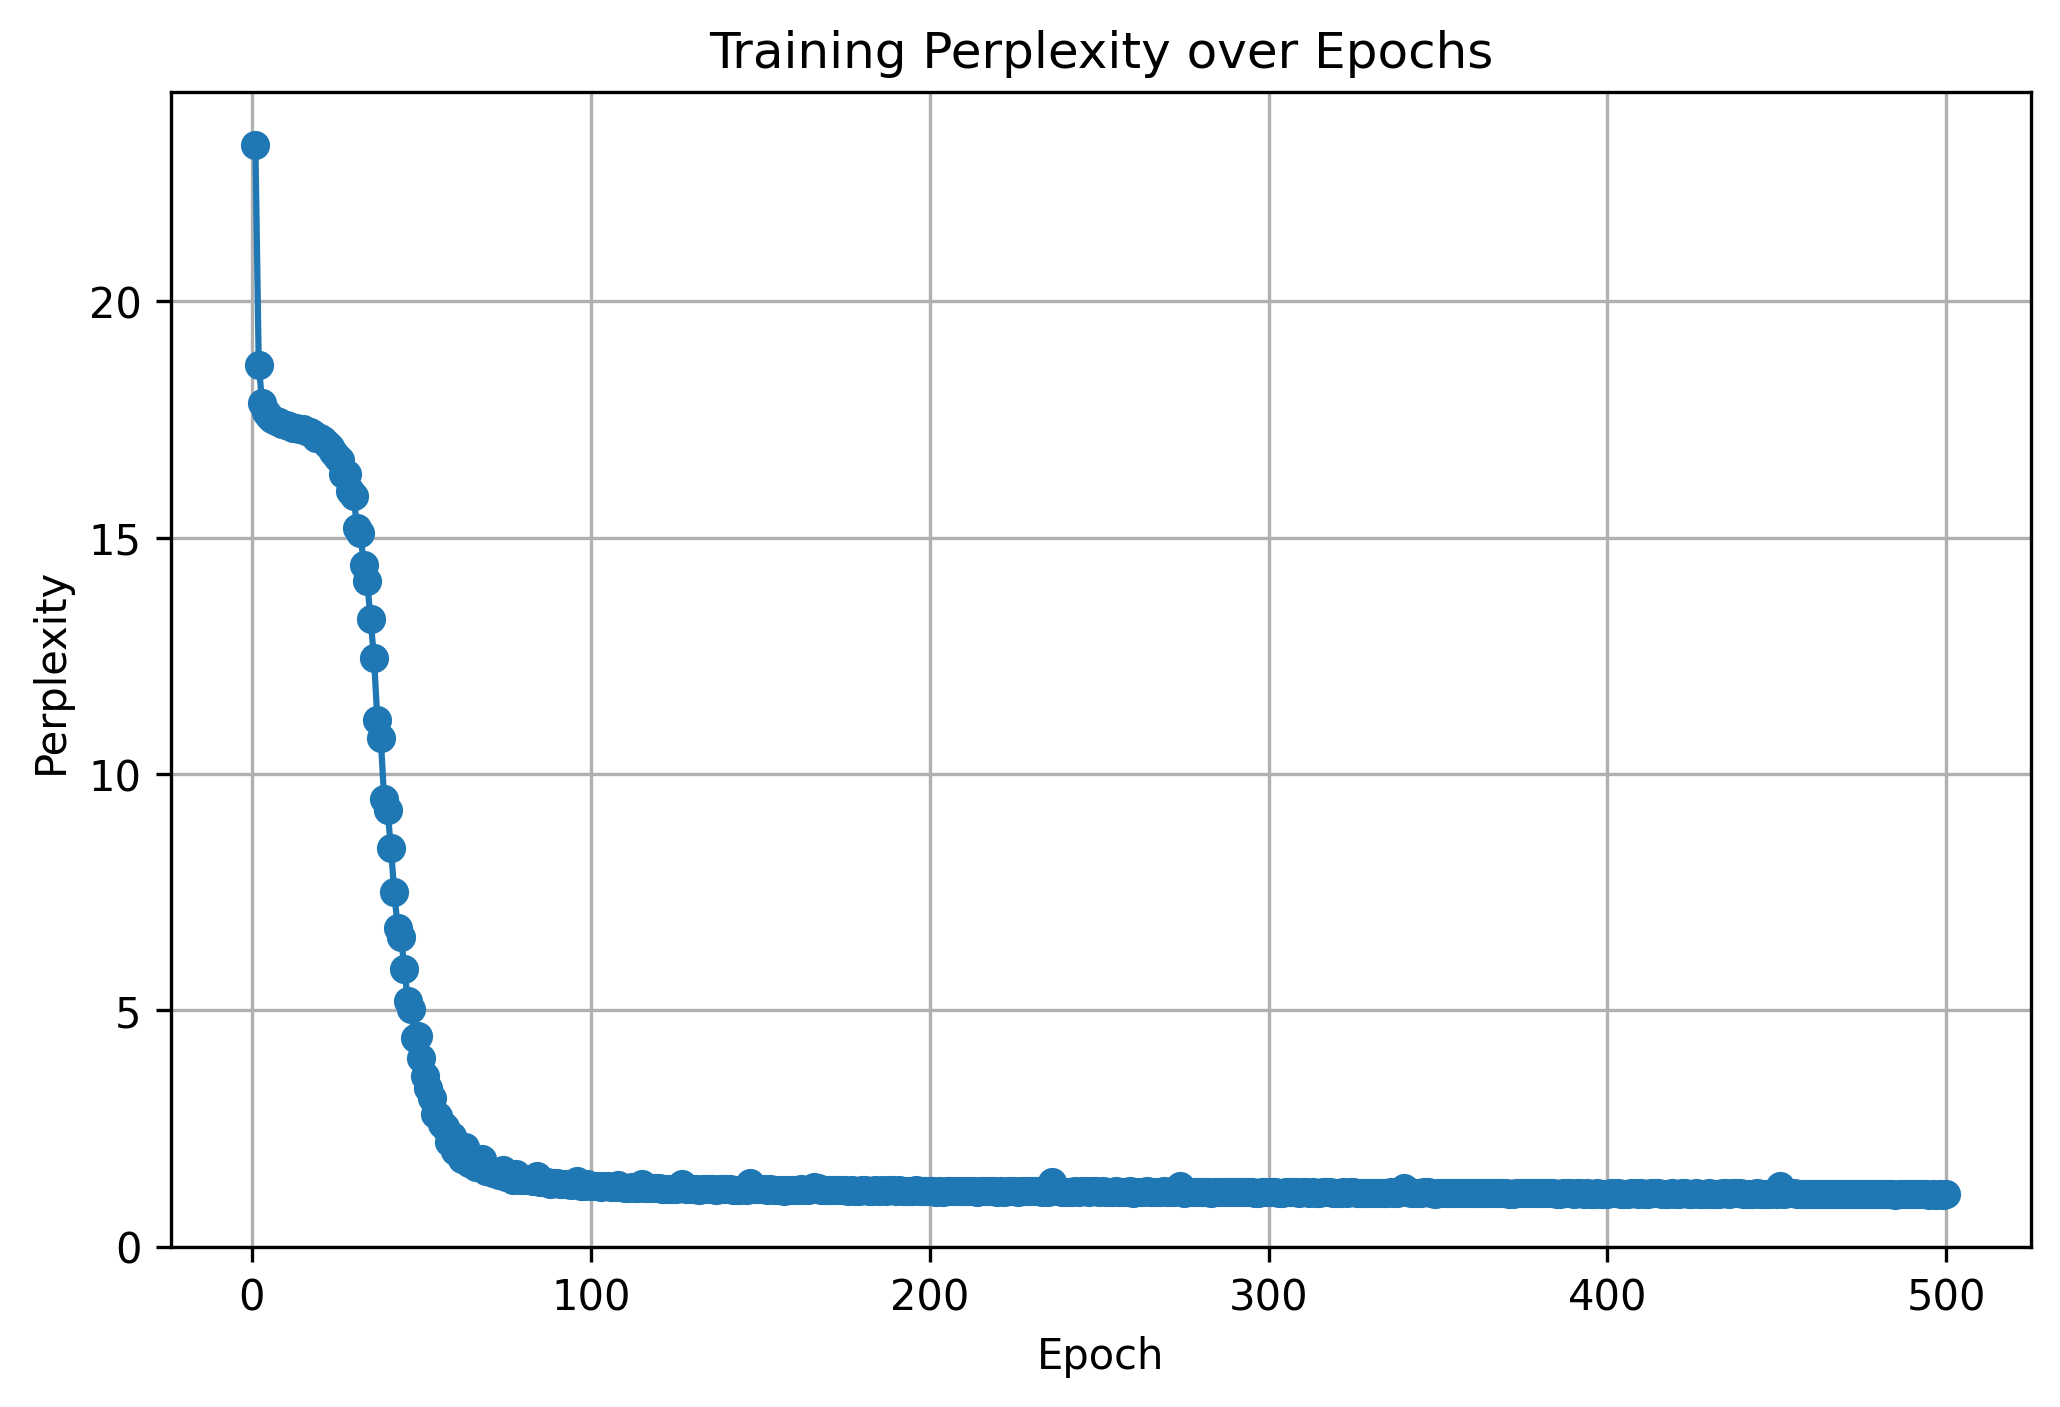

In [ ]:
import torch
from torch import nn

# 加载数据
batch_size, num_steps, device = 32, 35, "mps"
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 机器翻译

## 数据下载与数据预处理

In [228]:
import os
import zipfile
import urllib.request

def read_data_nmt():
    """
    超稳健版：载入“英语－法语”数据集。
    通过在解压前主动检查压缩包内容来精确定位和提取文件。
    """
    # 1. 设置路径
    data_url = 'http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip'
    data_dir = os.path.join('.', 'data')
    zip_path = os.path.join(data_dir, 'fra-eng.zip')
    # 最终的目标文件路径，我们期望它始终是 ./data/fra.txt
    target_file_path = os.path.join(data_dir, 'fra.txt')

    # 2. 确保数据目录存在
    os.makedirs(data_dir, exist_ok=True)

    # 3. 检查最终文件是否存在
    if not os.path.exists(target_file_path):
        print(f'目标文件 "{target_file_path}" 不存在，开始处理...')

        # 4. 确保zip文件已下载
        if not os.path.exists(zip_path):
            print(f'正在从 {data_url} 下载数据...')
            try:
                urllib.request.urlretrieve(data_url, zip_path)
                print(f'下载完成，文件保存在 "{zip_path}"')
            except Exception as e:
                print(f"下载失败: {e}")
                return None
        
        # 5. [核心修改] 智能检查并解压
        print(f'正在检查压缩包 "{zip_path}" 的内容...')
        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                # 获取zip包内所有文件的列表，用于调试和定位
                file_list = z.namelist()
                print(f'>>> 压缩包中的文件列表: {file_list}')

                # 从列表中寻找我们需要的.txt文件
                txt_file_in_zip = None
                for filename in file_list:
                    if filename.endswith('.txt'):
                        txt_file_in_zip = filename
                        print(f'>>> 在压缩包中找到目标文件: "{txt_file_in_zip}"')
                        break

                if txt_file_in_zip:
                    # 使用 extract 方法精确解压单个文件到 data_dir
                    z.extract(txt_file_in_zip, path=data_dir)
                    
                    # 解压后，文件的实际路径是 os.path.join(data_dir, txt_file_in_zip)
                    # 例如，如果zip包里是 'folder/fra.txt'，这里就会是 './data/folder/fra.txt'
                    extracted_file_actual_path = os.path.join(data_dir, txt_file_in_zip)
                    print(f'>>> 文件已解压到: "{extracted_file_actual_path}"')

                    # [重要] 如果解压后的路径不是我们期望的最终路径，就重命名/移动它
                    if os.path.normpath(extracted_file_actual_path) != os.path.normpath(target_file_path):
                        print(f'>>> 调整文件位置: 从 "{extracted_file_actual_path}" 移动到 "{target_file_path}"')
                        os.rename(extracted_file_actual_path, target_file_path)
                    print('>>> 文件已就绪。')
                else:
                    print("错误：在压缩包中未找到任何 .txt 文件。")
                    return None
        except Exception as e:
            print(f"处理压缩包时出错: {e}")
            return None
    else:
        print(f'文件 "{target_file_path}" 已存在，直接读取。')

    # 6. 读取文件
    try:
        with open(target_file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except FileNotFoundError:
        print(f"最终读取失败，文件 '{target_file_path}' 仍不存在。脚本无法自动解决此问题。")
        return None

# --- 执行代码 ---
raw_text = read_data_nmt()

if raw_text:
    print("\n--- 数据内容预览 ---")
    print(raw_text[:75])

文件 "./data/fra.txt" 已存在，直接读取。

--- 数据内容预览 ---
Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [229]:
len(raw_text)

11489286

In [230]:
# 文本预处理
def preprocess_nmt(raw_text):
    """
    处理原始文本，返回分词后的源语言和目标语言句子列表。
    """

    # 辅助函数，检测是否需要在字符前添加空格
    def no_space(char, prev_char):
        return char in ['.', '!', '?'] and prev_char != ' '
    
    # 将不间断空格替换为普通空格
    # 并将所有字符转换为小写
    text = raw_text.replace('\u202f', ' ').replace('\xa0', ' ').lower()

    # 标点前加入空格
    text = ''.join([' ' + char if no_space(char, text[i - 1]) else char for i, char in enumerate(text)])

    return text

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## 词元化

In [231]:
def tokenize_nmt(text, num_examples=None):
    """
    将处理后的文本分割为源语言和目标语言的句子对。
    返回两个列表：源语言句子和目标语言句子。
    """

    source = []
    target = []

    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].strip().split(" "))
            target.append(parts[1].strip().split(" "))

    return source, target

source, target = tokenize_nmt(text)
print(source[:3])
print(target[:3])

[['go', '.'], ['hi', '.'], ['run', '!']]
[['va', '!'], ['salut', '!'], ['cours', '!']]


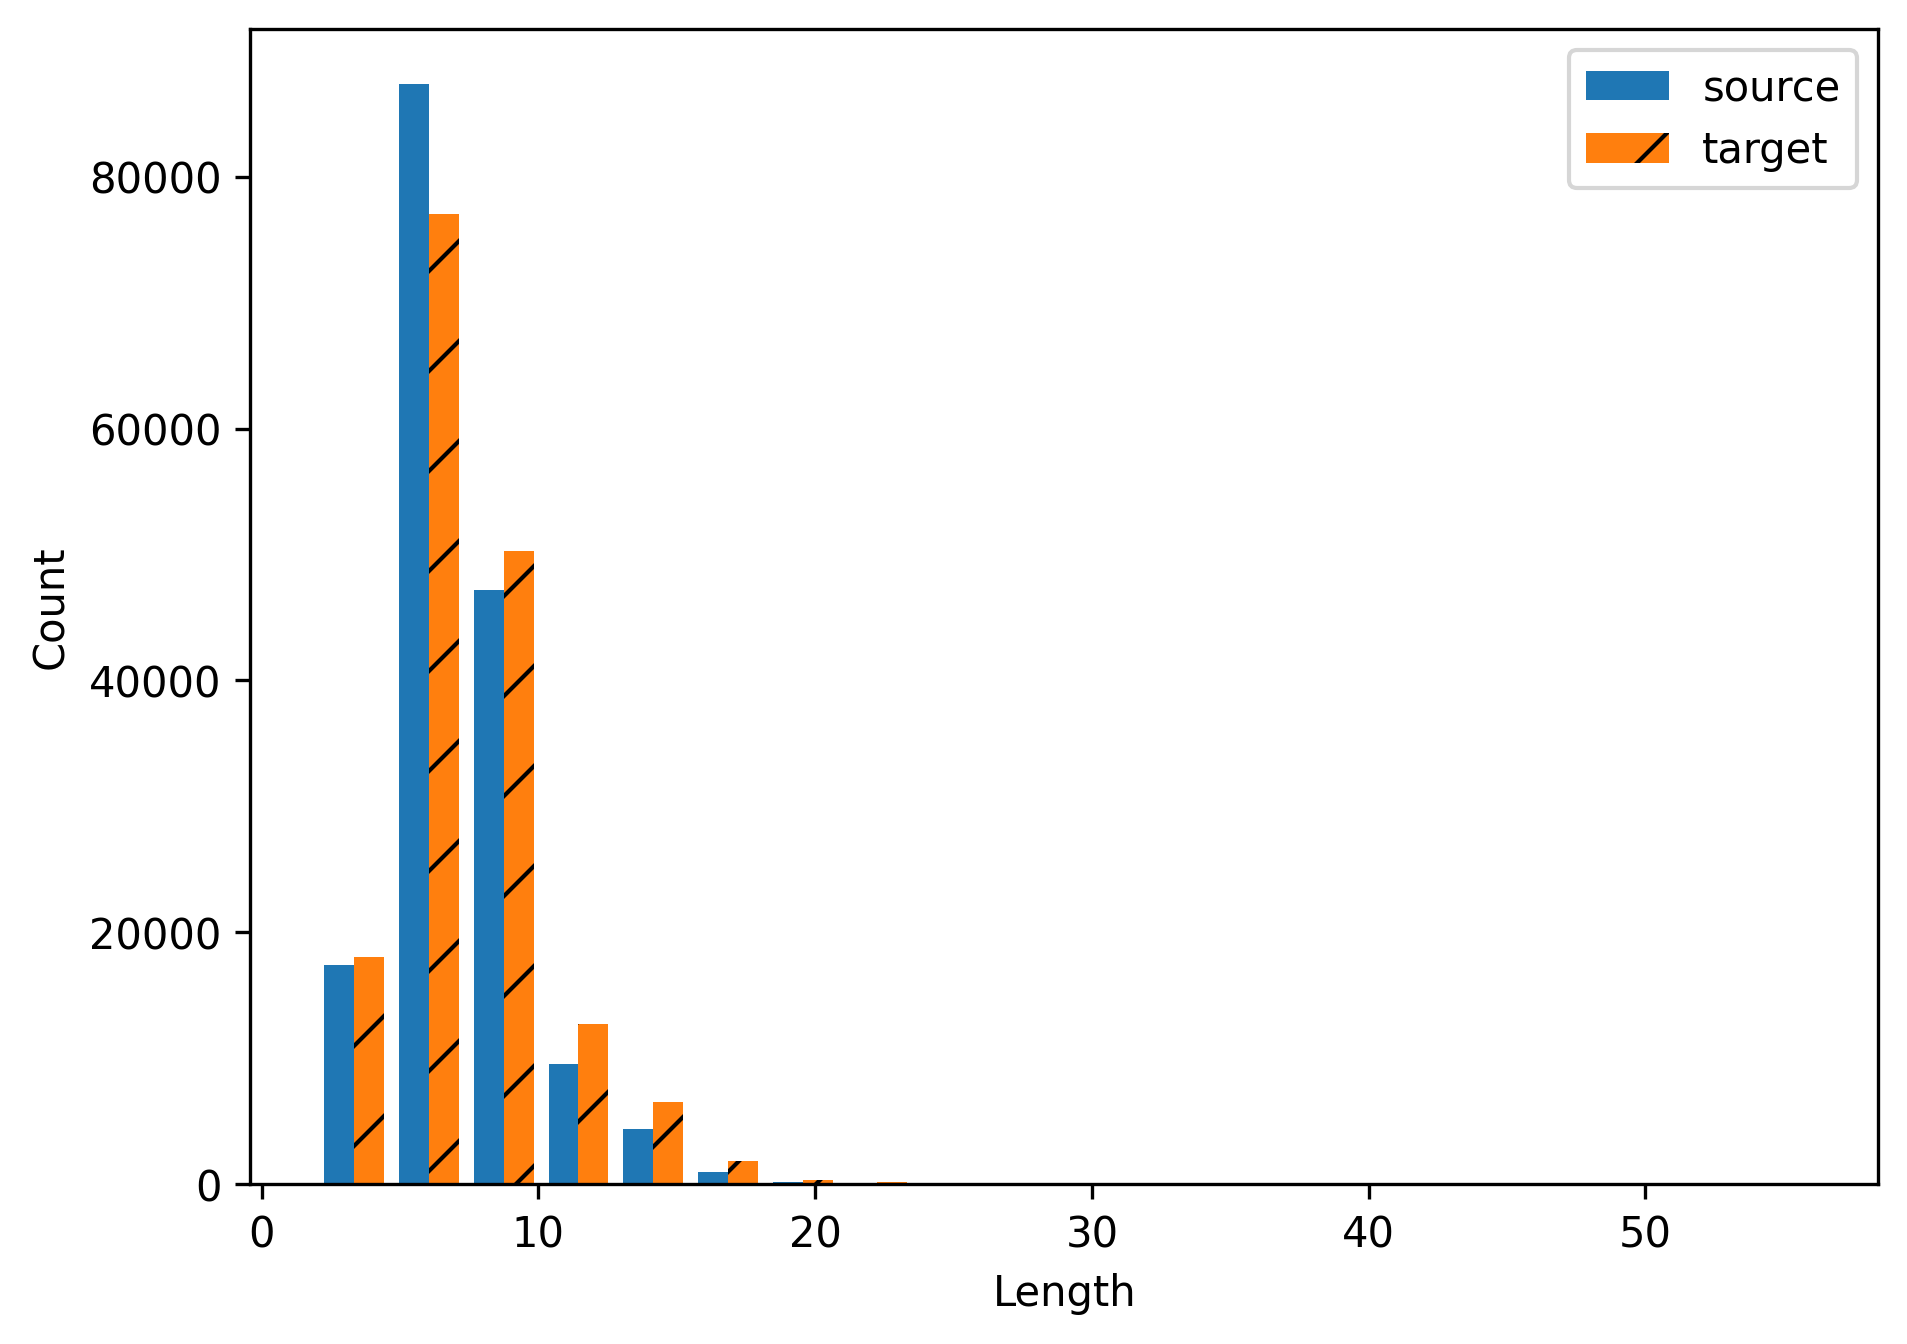

In [232]:
import matplotlib.pyplot as plt
from typing import List

def show_list_len_pair_hist(legend: List[str], 
                            xlabel: str, 
                            ylabel: str, 
                            xlist: List[List], 
                            ylist: List[List]):
    """
    绘制列表长度对的直方图 (不依赖d2l包)。
    :param legend: 图例，一个包含两个字符串的列表，例如 ['source', 'target']。
    :param xlabel: x轴标签。
    :param ylabel: y轴标签。
    :param xlist: 第一个数据列表 (例如 source)。
    :param ylist: 第二个数据列表 (例如 target)。
    """
    # 1. 设置图像大小
    plt.figure(figsize=(7, 5))

    # 2. 准备用于直方图的数据：计算每个序列的长度
    x_lengths = [len(l) for l in xlist]
    y_lengths = [len(l) for l in ylist]

    # 3. 绘制直方图
    # plt.hist 可以直接接收一个包含两个数据列表的列表
    # label参数用于后续生成图例
    _, _, patches = plt.hist(
        [x_lengths, y_lengths], 
        label=legend, 
        bins=20  # 可以指定条柱的数量以获得更平滑的视图
    )

    # 4. 设置x轴和y轴的标签
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # 5. 为第二个直方图的条柱添加斜线填充，以作区分
    # 这部分逻辑与d2l无关，可以直接保留
    for patch in patches[1].patches:
        patch.set_hatch('/')

    # 6. 显示图例
    plt.legend()

    # 7. 显示图像
    plt.show()

# 使用自定义函数绘制源语言和目标语言的长度分布直方图
show_list_len_pair_hist(
    legend=['source', 'target'],
    xlabel='Length',
    ylabel='Count',
    xlist=source,
    ylist=target
)

## 词表

In [233]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

src_vocab = Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10948

In [234]:
src_vocab.idx_to_token

['<unk>',
 '<pad>',
 '<bos>',
 '<eos>',
 '.',
 'i',
 'you',
 'to',
 'the',
 '?',
 'a',
 'is',
 'tom',
 'that',
 'he',
 'of',
 'do',
 'it',
 'this',
 'in',
 'me',
 'have',
 "don't",
 'was',
 'my',
 'are',
 'for',
 'your',
 'what',
 "i'm",
 'we',
 'be',
 'want',
 'she',
 'not',
 'know',
 'like',
 'on',
 'with',
 'can',
 'his',
 'all',
 'did',
 'at',
 "you're",
 'how',
 'they',
 'go',
 'him',
 'think',
 'and',
 "it's",
 'about',
 "can't",
 'time',
 'very',
 'here',
 "didn't",
 'get',
 'there',
 'her',
 'were',
 'as',
 'will',
 'had',
 'if',
 'why',
 'just',
 'out',
 'has',
 'no',
 'one',
 'up',
 'going',
 'would',
 'so',
 'good',
 'need',
 'tell',
 'an',
 "i'll",
 'see',
 'when',
 'come',
 'from',
 'by',
 'really',
 'mary',
 'who',
 'please',
 'help',
 "that's",
 'us',
 'should',
 'could',
 'been',
 "i've",
 'never',
 'where',
 'more',
 'take',
 'now',
 'something',
 'got',
 'too',
 'than',
 'make',
 'much',
 'some',
 "i'd",
 "we're",
 'but',
 'right',
 'am',
 'work',
 'any',
 'money',
 '

## 加载数据集

In [235]:
source[0]

['go', '.']

In [236]:
vocab[source[0]]

[0, 0]

In [237]:
def truncate_pad(line, num_step, padding_token):
    # 截断或填充序列
    # 输入的line是一个列表，num_step是期望的长度，padding_token是填充的标记
    if len(line) > num_step:
        return line[:num_step]
    return line + [padding_token] * (num_step - len(line))


truncate_pad(src_vocab[source[0]], 10, src_vocab["<pad>"])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [238]:
def build_array_nmt(lines, vocab, num_steps):
    """
    将文本行转换为数字索引，并进行截断或填充。
    :param lines: 文本行列表。
    :param vocab: 词汇表对象。
    :param num_steps: 期望的序列长度。
    :return: 数字索引的张量。
    """
    # 将每个文本行转换为数字索引
    lines = [vocab[line] for line in lines]
    # 添加结束标记
    lines = [line + [vocab['<eos>']] for line in lines]
    # 截断或填充每个行
    lines = [truncate_pad(line, num_steps, vocab['<pad>']) for line in lines]
    # 转换为张量
    lines = torch.tensor(lines)
    # 计算有效长度
    valid_len = (lines != vocab['<pad>']).type(torch.int32).sum(1)
    # 返回数字索引的张量和有效长度
    return lines, valid_len


build_array_nmt(source[:3], src_vocab, 10)

(tensor([[  47,    4,    3,    1,    1,    1,    1,    1,    1,    1],
         [3282,    4,    3,    1,    1,    1,    1,    1,    1,    1],
         [ 432,  122,    3,    1,    1,    1,    1,    1,    1,    1]]),
 tensor([3, 3, 3]))

In [239]:
print(vocab.idx_to_token)

['<unk>', ' ', 'e', 't', 'a', 'i', 'n', 'o', 's', 'h', 'r', 'd', 'l', 'm', 'u', 'c', 'f', 'w', 'g', 'y', 'p', 'b', 'v', 'k', 'x', 'z', 'j', 'q']


In [240]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    # 数据提取与预处理
    raw_text = read_data_nmt()
    text = preprocess_nmt(raw_text)

    # 词元化
    source, target = tokenize_nmt(text, num_examples)
    
    # 词表
    src_vocab = Vocab(source, min_freq=1, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=1, reserved_tokens=['<pad>', '<bos>', '<eos>'])

    # 加载数据集，即将文本行转换为数字索引，并进行截断或填充
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    # 创建数据集
    dataset = torch.utils.data.TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)

    # 创建数据加载器
    data_iter = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_iter, src_vocab, tgt_vocab

In [241]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

文件 "./data/fra.txt" 已存在，直接读取。
X: tensor([[  7, 150,   4,   3,   1,   1,   1,   1],
        [ 37,  21,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[  6,   7, 166,   4,   3,   1,   1,   1],
        [ 30, 270,  22,   4,   3,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([5, 5])


# 编码器-解码器架构

In [242]:
from torch import nn


#@save
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [243]:
#@save
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [244]:
#@save
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

# 序列到序列学习（seq2seq）

In [245]:
import collections
import math
import torch
from torch import nn

In [246]:
#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [247]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [248]:
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输入'X'的形状：(batch_size,num_steps,embed_size)
        # 转化为 (num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [249]:
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [250]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

# (torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [251]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

# tensor([[1, 0, 0],
#         [4, 5, 0]])

tensor([[1, 0, 0],
        [4, 5, 0]])

In [252]:
#@save
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [253]:
state.shape

torch.Size([2, 4, 16])

In [254]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

# (torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [255]:
X

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])

In [256]:
torch.arange((5), dtype=torch.float32)[None, :]

tensor([[0., 1., 2., 3., 4.]])

In [257]:
torch.arange(5)[:, None]

tensor([[0],
        [1],
        [2],
        [3],
        [4]])

In [258]:
torch.arange((5), dtype=torch.float32)[None, :] < torch.tensor([3, 4, 2, 1, 0])[:, None]

tensor([[ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True, False, False, False],
        [ True, False, False, False, False],
        [False, False, False, False, False]])

In [259]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

# tensor([[1, 0, 0],
#         [4, 5, 0]])

tensor([[1, 0, 0],
        [4, 5, 0]])

In [260]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [261]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [262]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型 (不依赖d2l包)"""
    import time
    
    # --- 1. 初始化 ---
    
    # 定义权重初始化函数
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    
    # 用于存储每个epoch的损失，以便后续绘图
    epoch_losses = []
    
    print("开始训练...")
    for epoch in range(num_epochs):
        # --- 2. 训练一个 Epoch ---
        start_time = time.time()
        # 替代 d2l.Accumulator
        total_loss = 0
        total_tokens = 0
        
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            
            # 准备解码器的输入（强制教学）
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            
            # 前向传播
            Y_hat, _ = net(X, dec_input, X_valid_len)
            
            # 计算损失
            l = loss(Y_hat, Y, Y_valid_len)
            l = l.sum()
            
            # 反向传播
            l.backward()
            
            # 梯度裁剪 (替代 d2l.grad_clipping)
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            
            # 累加损失和词元数
            total_loss += l.item()
            total_tokens += num_tokens.item()

        # --- 3. 记录和打印 Epoch 信息 ---
        duration = time.time() - start_time
        avg_loss = total_loss / total_tokens
        epoch_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Loss: {avg_loss:.3f}, '
                  f'{total_tokens / duration:.1f} tokens/sec on {str(device)}')

    print("训练完成。")

    # --- 4. 训练后绘图 ---
    print("绘制损失曲线...")
    plt.figure(figsize=(7, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.title('Training Loss Curve')
    plt.show()

In [263]:
src_vocab['<eos>']

3

文件 "./data/fra.txt" 已存在，直接读取。
开始训练...
Epoch 10/300, Loss: 0.306, 5105.7 tokens/sec on mps
Epoch 20/300, Loss: 0.230, 5138.5 tokens/sec on mps
Epoch 30/300, Loss: 0.187, 5042.1 tokens/sec on mps
Epoch 40/300, Loss: 0.150, 5179.3 tokens/sec on mps
Epoch 50/300, Loss: 0.125, 5007.7 tokens/sec on mps
Epoch 60/300, Loss: 0.108, 5216.3 tokens/sec on mps
Epoch 70/300, Loss: 0.095, 5227.9 tokens/sec on mps
Epoch 80/300, Loss: 0.086, 5100.6 tokens/sec on mps
Epoch 90/300, Loss: 0.078, 5168.4 tokens/sec on mps
Epoch 100/300, Loss: 0.071, 5211.3 tokens/sec on mps
Epoch 110/300, Loss: 0.066, 5006.0 tokens/sec on mps
Epoch 120/300, Loss: 0.061, 5178.7 tokens/sec on mps
Epoch 130/300, Loss: 0.057, 5082.9 tokens/sec on mps
Epoch 140/300, Loss: 0.053, 5117.3 tokens/sec on mps
Epoch 150/300, Loss: 0.048, 5256.2 tokens/sec on mps
Epoch 160/300, Loss: 0.045, 5239.8 tokens/sec on mps
Epoch 170/300, Loss: 0.041, 5152.3 tokens/sec on mps
Epoch 180/300, Loss: 0.039, 4584.6 tokens/sec on mps
Epoch 190/300, Lo

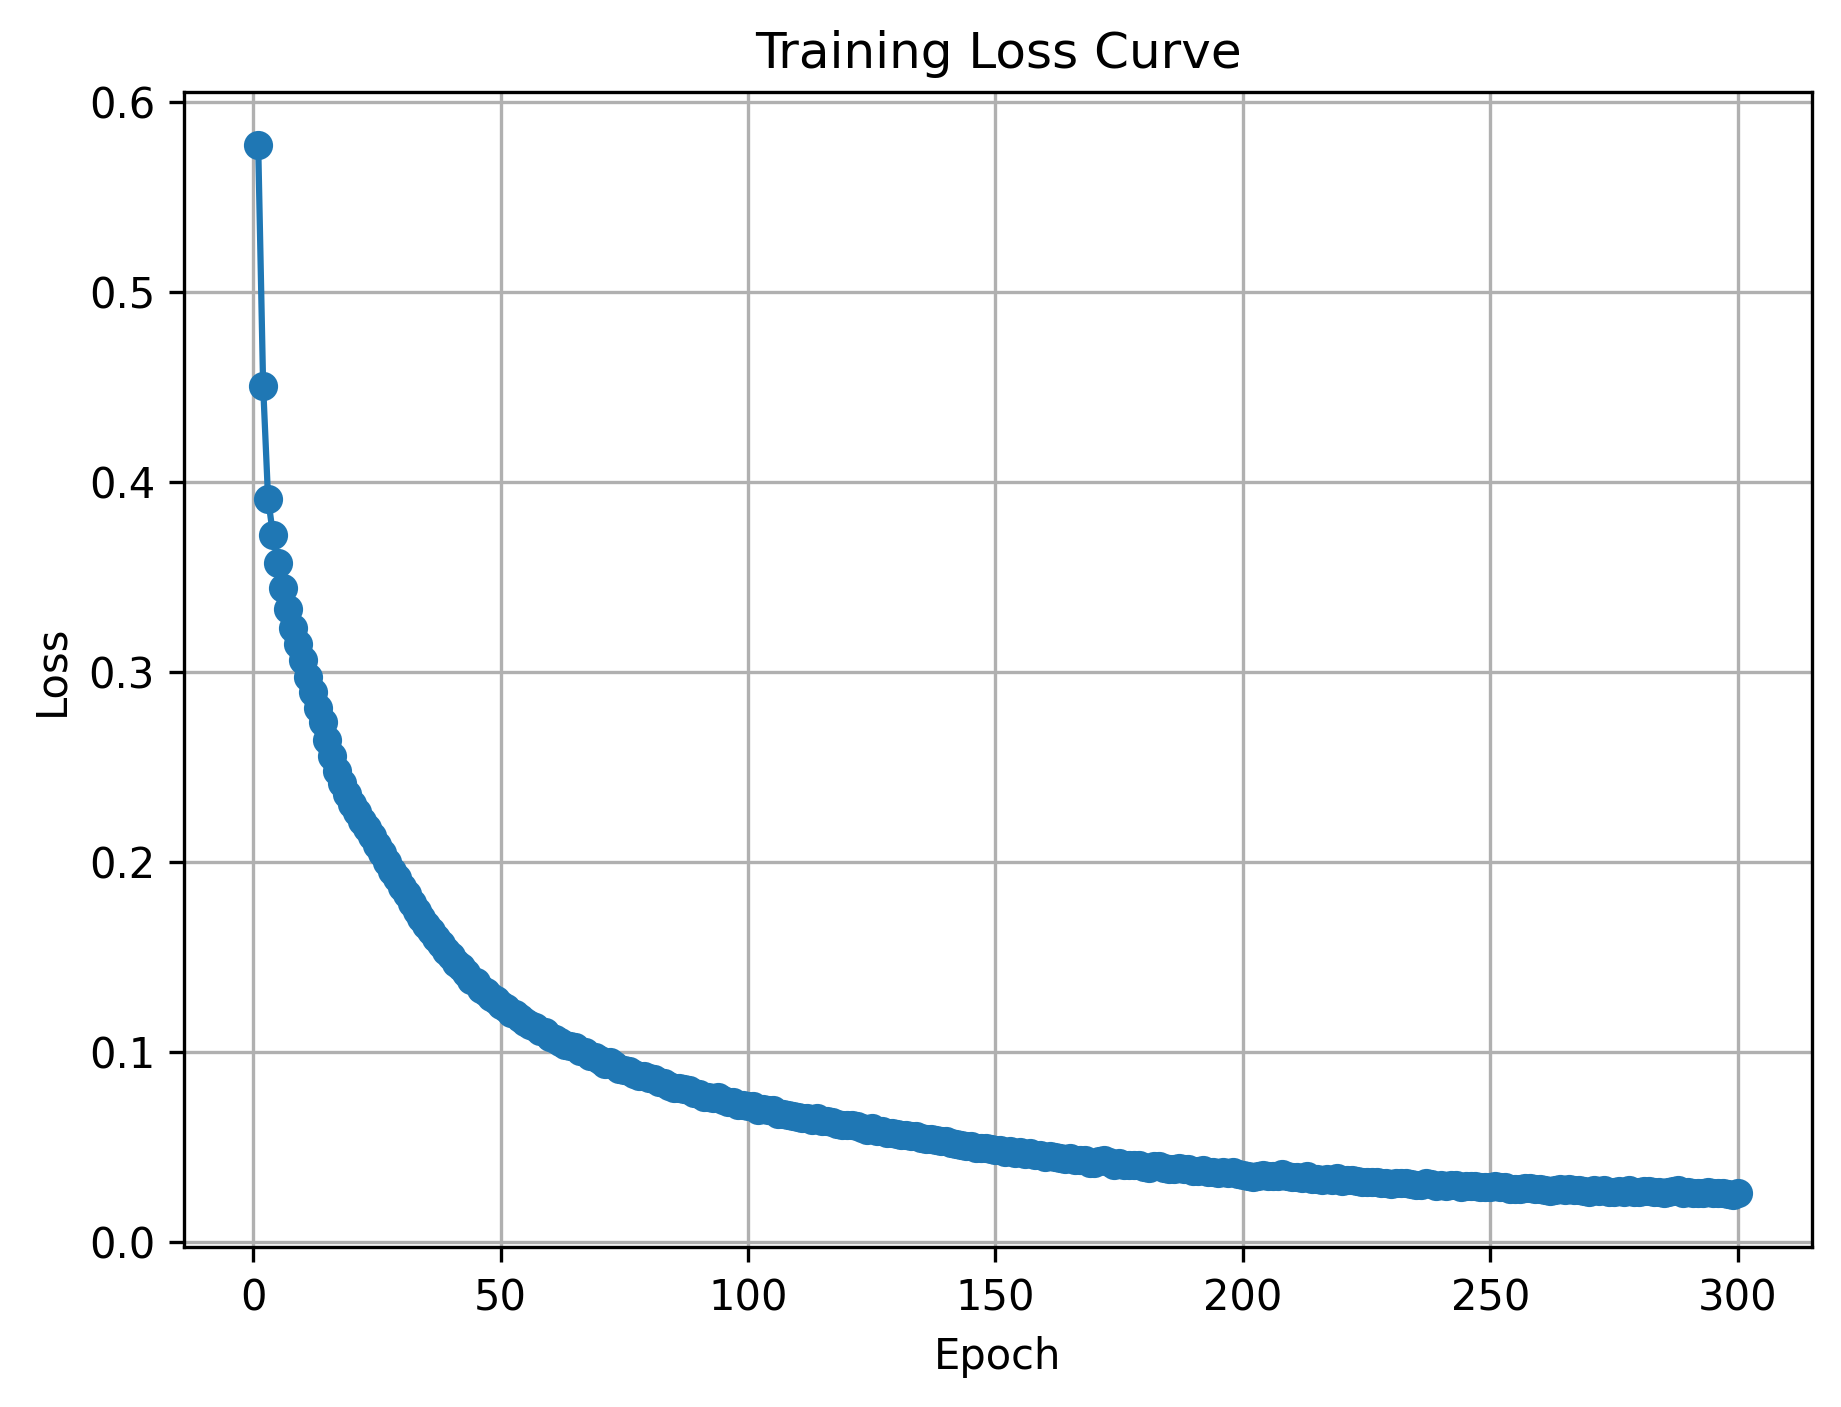

In [264]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, "mps"

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [265]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充


#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [266]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [267]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis !, bleu 0.353


In [268]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis !, bleu 0.353
